In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import numba
from scipy.linalg import expm

from src import GWParameters, GWModel
from CRU import *
from markov_utils import *

matplotlib.style.use('seaborn-v0_8-dark-palette')
FIG_HEIGHT = 12

In [2]:
NCaRU_x, NCaRU_y = 100, 100

XKr = np.array([0.999503, 4.13720e-4, 7.27568e-5, 8.73984e-6, 1.36159e-6])
XKv14 = np.array([0.953060, 0.0253906, 2.53848e-4, 1.12796e-6, 1.87950e-9, 0.0151370, 0.00517622, 8.96600e-4, 8.17569e-5, 2.24032e-6])
XKv43 = np.array([0.722328, 0.101971, 0.00539932, 1.27081e-4, 1.82742e-6, 0.152769, 0.00962328, 0.00439043, 0.00195348, 0.00143629])

CaSS = np.ones((NCaRU_x, NCaRU_y)) * 1.45370e-4
CaJSR = np.ones((NCaRU_x, NCaRU_y)) * 0.908408
LCC = np.random.choice([1, 2, 7], p=[0.958, 0.038, 0.004], size=(NCaRU_x, NCaRU_y))
LCC_inactivation = np.random.choice([0, 1], p=[0.0575, 0.9425], size=(NCaRU_x, NCaRU_y))
ClCh = np.random.choice([0, 1], p=[0.998, 0.002], size=(NCaRU_x, NCaRU_y))
RyR = np.zeros((NCaRU_x, NCaRU_y, 6), dtype=np.int32)
for i in range(NCaRU_x):
    for j in range(NCaRU_y):
        for k in range(5):
            idx = np.random.choice([0, 4, 5], p=[0.609, 0.5*0.391, 0.5*0.391])
            RyR[i, j, idx] += 1


init_state = {
    "V": -91.382,
    "Nai": 10.0,
    "Ki": 131.84,
    "Cai": 1.45273e-4,
    "CaNSR": 0.908882,
    "CaLTRPN": 8.9282e-3,
    "CaHTRPN": 0.137617,
    "m": 5.33837e-4,
    "h": 0.996345,
    "j": 0.997315,
    "xKs": 2.04171e-4,
    "XKr": XKr,
    "XKv14": XKv14,
    "XKv43": XKv43,

    "CaSS": CaSS,
    "CaJSR": CaJSR,
    "LCC": LCC,
    "LCC_inactivation": LCC_inactivation,
    "RyR": RyR,
    "ClCh": ClCh
}

In [3]:
params = GWParameters(lattice=True, NCaRU_x=NCaRU_x, NCaRU_y=NCaRU_y) # Create parameters object using default values
Istim = lambda t: 20 if (t % 700) < 2 else 0 # Stimulus function

model = GWModel(parameters=params, stimulus_fn=Istim, init_state=init_state) # Convenience wrapper around C++ function

In [4]:
step_size = 1e-3 # Pick a small step size for accuracy and to reduce bias from parallelising the SSA
num_steps = 20_000 # Simulate the AP for 500ms
record_every = 500 # Record the state every 500 steps (0.5 ms)

In [5]:
%%time
sim = model.simulate(step_size=step_size, num_steps=num_steps, record_every=record_every)

CPU times: user 3min 34s, sys: 5.43 s, total: 3min 40s
Wall time: 14.2 s


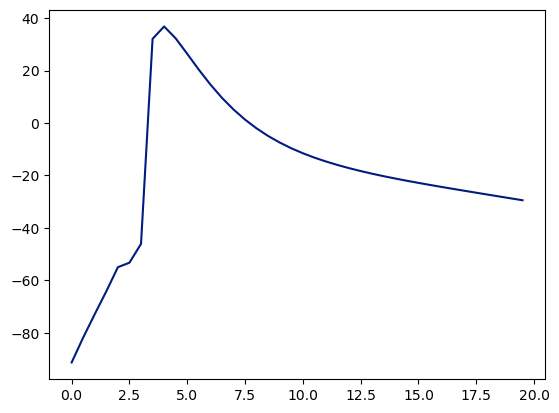

In [6]:
plt.plot(sim.t, sim.V)
plt.show()

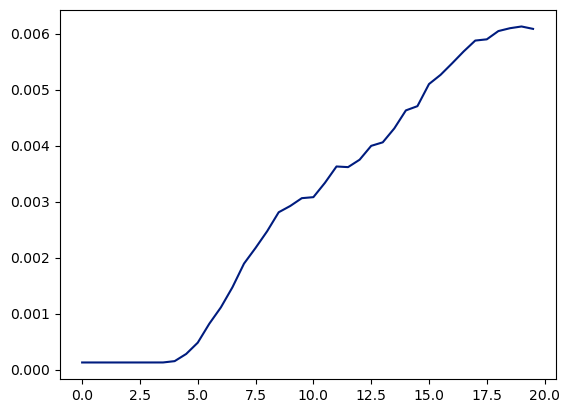

In [7]:
plt.plot(sim.t, sim.CaSS.mean(axis=(1,2)))
plt.show()

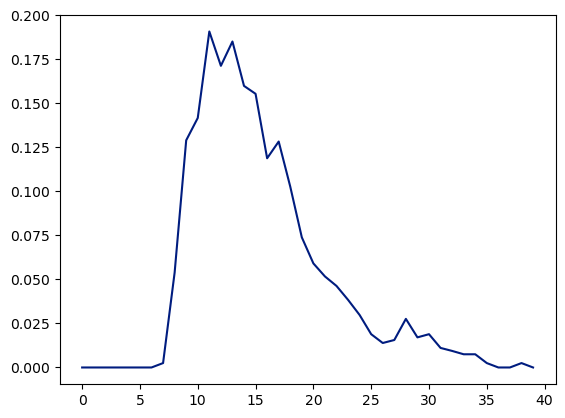

In [8]:
plt.plot((sim.LCC == 6).mean(axis=(1,2)))
plt.show()

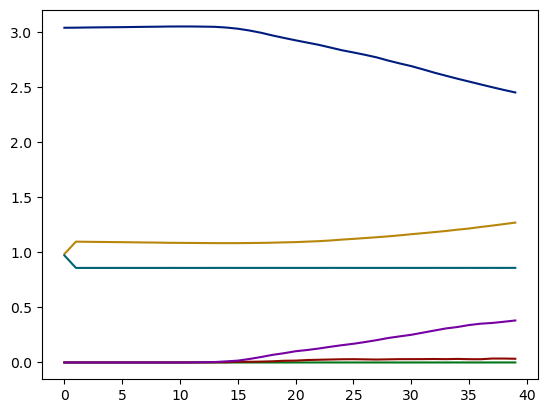

In [9]:
plt.plot((sim.RyR).mean(axis=(1,2)))
plt.show()

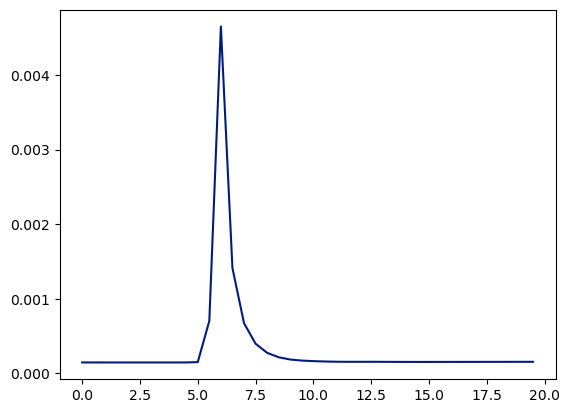

In [16]:
plt.plot(sim.t, sim.CaSS[:, 1,1])
plt.show()

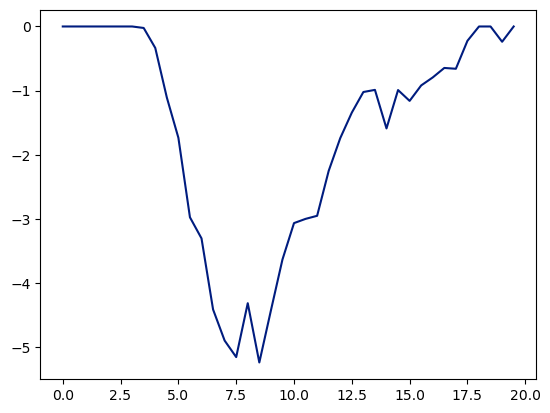

In [11]:
plt.plot(sim.t, sim.ICaL)
plt.show()

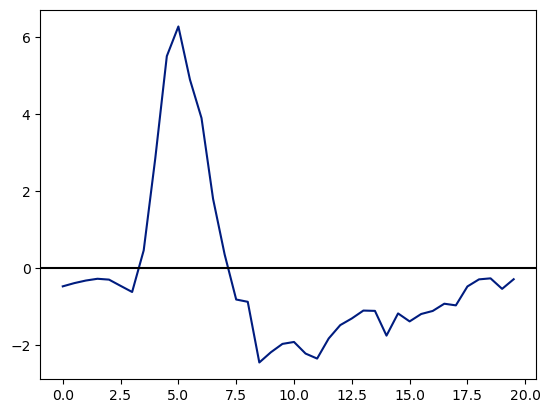

In [12]:
plt.plot(sim.t, sim.ICaL + sim.IKr + sim.IKs + sim.Ito1 + sim.IKp + sim.Ito2 + sim.INaK + sim.INaCa + sim.IpCa + sim.ICab + sim.INab)
plt.axhline(y=0, color='k')
plt.show()

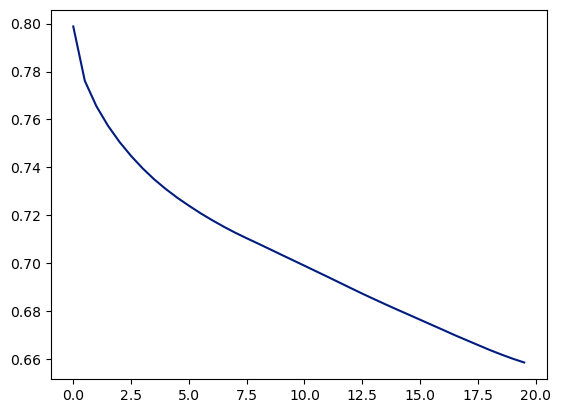

In [13]:
plt.plot(sim.t, sim.CaJSR.mean(axis=(1,2)))
plt.show()

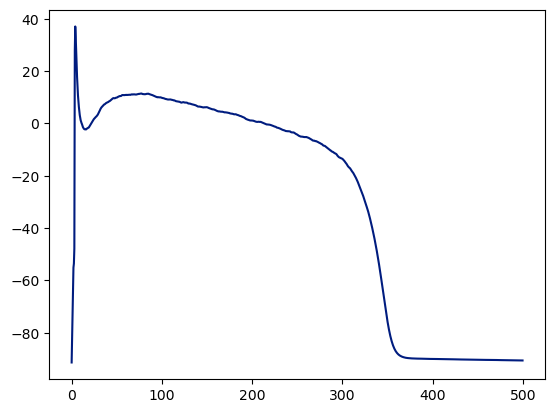

In [41]:
plt.plot(sim.t, sim.V)
plt.show()

In [8]:
print(np.min(sim.CaSS), np.max(sim.CaSS))

0.00014484295251219017 0.0797512138993306


In [18]:
mean_sojourn_times = np.zeros((sim.t.shape[0], 10))

In [19]:
for i in range(sim.t.shape[0]):
    Q_ = LCC_Q_no_open(params, sim.V[i], sim.CaSS[i].mean())
    mean_sojourn_times[i, :] = np.linalg.solve(Q_, -np.ones(10))

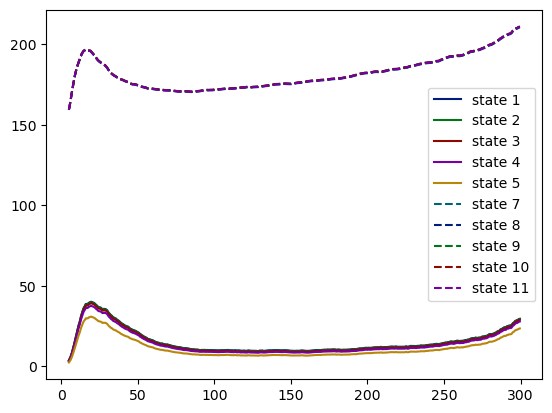

In [50]:
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 0], label="state 1")
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 1], label="state 2")
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 2], label="state 3")
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 3], label="state 4")
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 4], label="state 5")
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 5], label="state 7", linestyle='--')
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 6], label="state 8", linestyle='--')
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 7], label="state 9", linestyle='--')
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 8], label="state 10", linestyle='--')
plt.plot(sim.t[10:600], mean_sojourn_times[10:600, 9], label="state 11", linestyle='--')
plt.legend()
plt.show()

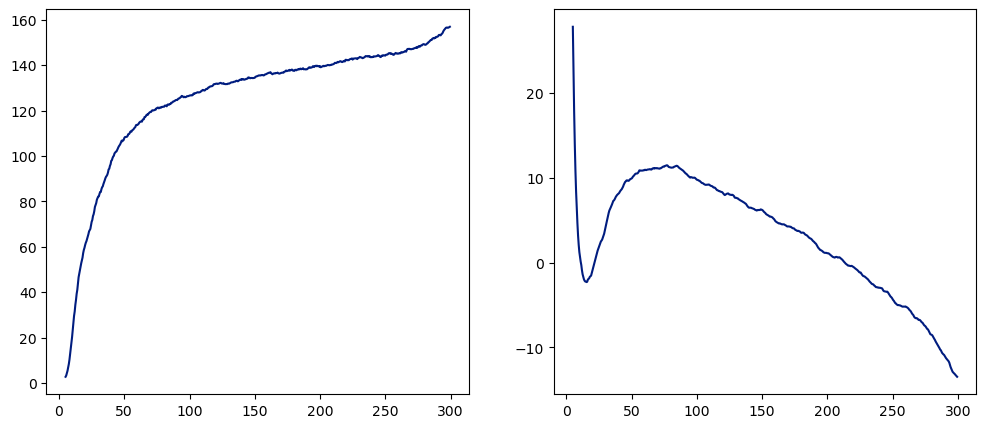

In [54]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
mst = (mean_sojourn_times[:, 0] * (sim.LCC == 1).mean(axis=(1,2)) + mean_sojourn_times[:, 1] * (sim.LCC == 2).mean(axis=(1,2)) + mean_sojourn_times[:, 2] * (sim.LCC == 3).mean(axis=(1,2)) + mean_sojourn_times[:, 3] * (sim.LCC == 4).mean(axis=(1,2))
     + mean_sojourn_times[:, 4] * (sim.LCC == 5).mean(axis=(1,2)) + mean_sojourn_times[:, 5] * (sim.LCC == 7).mean(axis=(1,2)) + mean_sojourn_times[:, 6] * (sim.LCC == 8).mean(axis=(1,2)) + mean_sojourn_times[:, 7] * (sim.LCC == 9).mean(axis=(1,2))
     + mean_sojourn_times[:, 8] * (sim.LCC == 10).mean(axis=(1,2)) + mean_sojourn_times[:, 9] * (sim.LCC == 11).mean(axis=(1,2)))
ax[0].plot(sim.t[10:600], mst[10:600])
ax[1].plot(sim.t[10:600], sim.V[10:600])
plt.show()

In [55]:
snd_moment_sojourn_times = np.zeros((sim.t.shape[0], 10))
for i in range(1000):
    Q_ = LCC_Q_no_open(params, sim.V[i], sim.CaSS[i].mean())
    snd_moment_sojourn_times[i, :] = np.linalg.solve(Q_, -2*mean_sojourn_times[i,:])

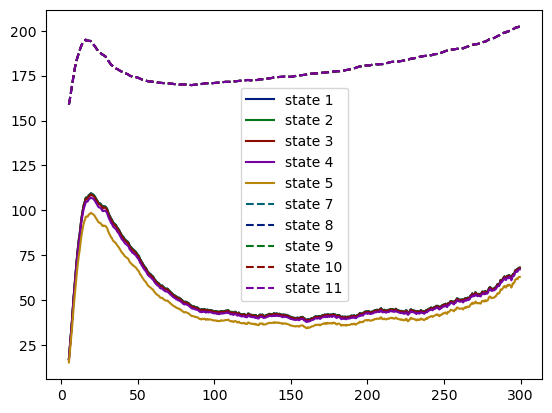

In [58]:
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 0] - mean_sojourn_times[10:600,0]**2), label="state 1")
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 1] - mean_sojourn_times[10:600,1]**2), label="state 2")
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 2] - mean_sojourn_times[10:600,2]**2), label="state 3")
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 3] - mean_sojourn_times[10:600,3]**2), label="state 4")
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 4] - mean_sojourn_times[10:600,4]**2), label="state 5")
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 5] - mean_sojourn_times[10:600,5]**2), label="state 7", linestyle='--')
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 6] - mean_sojourn_times[10:600,6]**2), label="state 8", linestyle='--')
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 7] - mean_sojourn_times[10:600,7]**2), label="state 9", linestyle='--')
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 8] - mean_sojourn_times[10:600,8]**2), label="state 10", linestyle='--')
plt.plot(sim.t[10:600], np.sqrt(snd_moment_sojourn_times[10:600, 9] - mean_sojourn_times[10:600,9]**2), label="state 11", linestyle='--')
plt.legend()
plt.show()

In [59]:
snd_mst = (snd_moment_sojourn_times[:, 0] * (sim.LCC == 1).mean(axis=(1,2)) + snd_moment_sojourn_times[:, 1] * (sim.LCC == 2).mean(axis=(1,2)) + snd_moment_sojourn_times[:, 2] * (sim.LCC == 3).mean(axis=(1,2)) 
           + snd_moment_sojourn_times[:, 3] * (sim.LCC == 4).mean(axis=(1,2)) + snd_moment_sojourn_times[:, 4] * (sim.LCC == 5).mean(axis=(1,2)) + snd_moment_sojourn_times[:, 5] * (sim.LCC == 7).mean(axis=(1,2)) 
           + snd_moment_sojourn_times[:, 6] * (sim.LCC == 8).mean(axis=(1,2)) + snd_moment_sojourn_times[:, 7] * (sim.LCC == 9).mean(axis=(1,2)) + snd_moment_sojourn_times[:, 8] * (sim.LCC == 10).mean(axis=(1,2)) 
           + snd_moment_sojourn_times[:, 9] * (sim.LCC == 11).mean(axis=(1,2)))

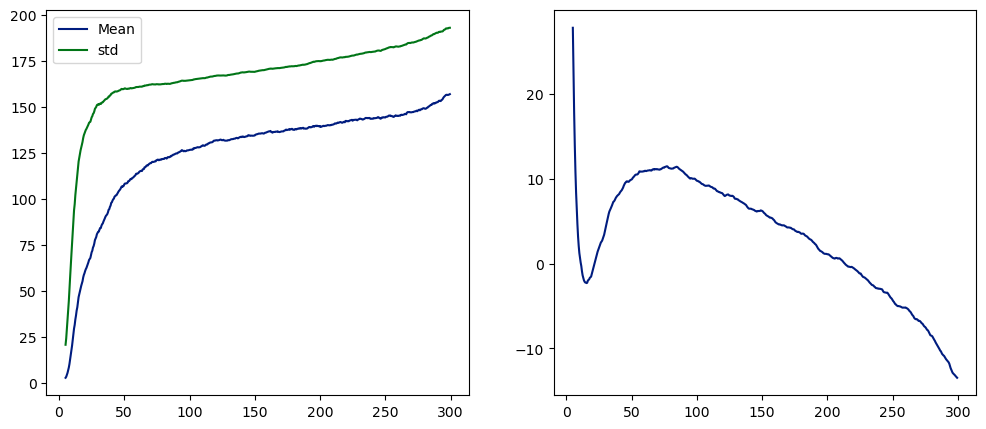

In [62]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax[0].plot(sim.t[10:600], mst[10:600], label="Mean")
ax[0].plot(sim.t[10:600], np.sqrt(snd_mst[10:600] - mst[10:600]**2), label="std")
ax[0].legend()
ax[1].plot(sim.t[10:600], sim.V[10:600])
plt.show()

In [94]:
sojourn_dist = np.zeros((10_000, 10))
ts = np.linspace(0,1000,num=10_000)
Q = LCC_Q_no_open(params, sim.V[300], sim.CaSS[300].mean())
expQ = expm((ts[1]-ts[0])*Q)
sojourn_dist[0, :] = np.clip(-Q @ np.ones(10), a_min=0.0, a_max=np.inf)
for i, t in enumerate(ts[1:]):
    sojourn_dist[i+1, :] = np.clip(expQ @ sojourn_dist[i, :], a_min=0.0, a_max=np.inf)

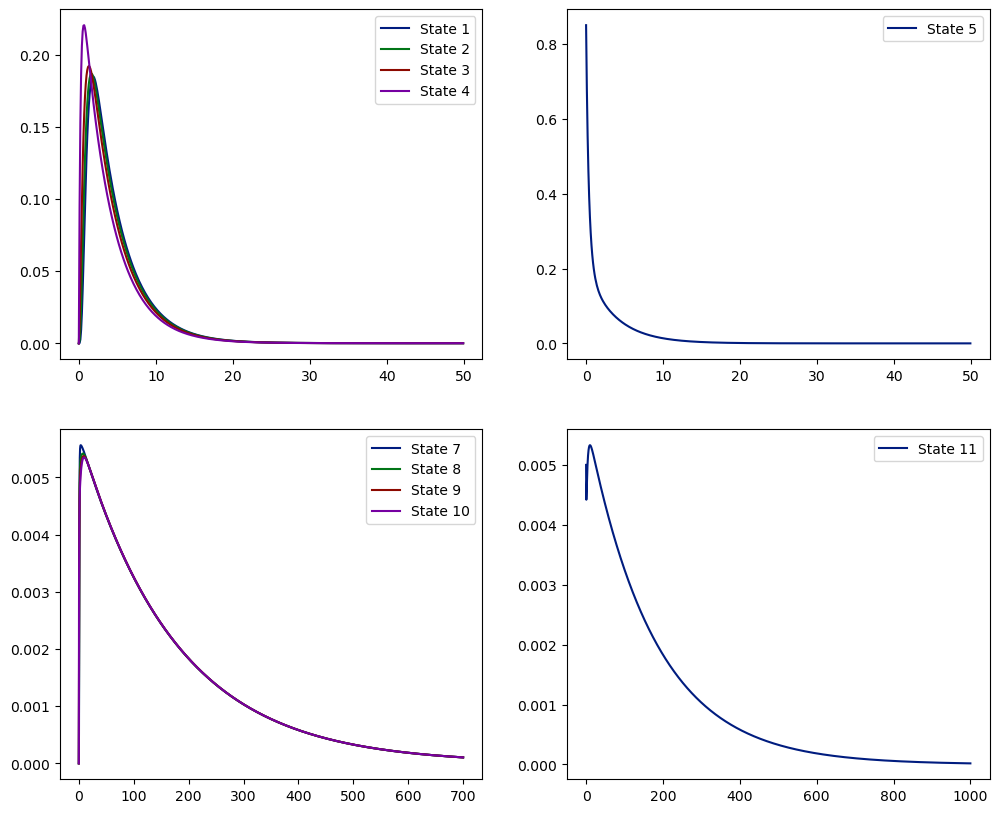

In [105]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(ts[:500], sojourn_dist[:500,0], label="State 1")
ax[0,0].plot(ts[:500], sojourn_dist[:500,1], label="State 2")
ax[0,0].plot(ts[:500], sojourn_dist[:500,2], label="State 3")
ax[0,0].plot(ts[:500], sojourn_dist[:500,3], label="State 4")
ax[0,0].legend()

ax[0,1].plot(ts[:500], sojourn_dist[:500,4], label="State 5")
ax[0,1].legend()

ax[1,0].plot(ts[:7000], sojourn_dist[:7000,5], label="State 7")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,6], label="State 8")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,7], label="State 9")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,8], label="State 10")
ax[1,0].legend()

ax[1,1].plot(ts, sojourn_dist[:,9], label="State 11")
ax[1,1].legend()
plt.show()

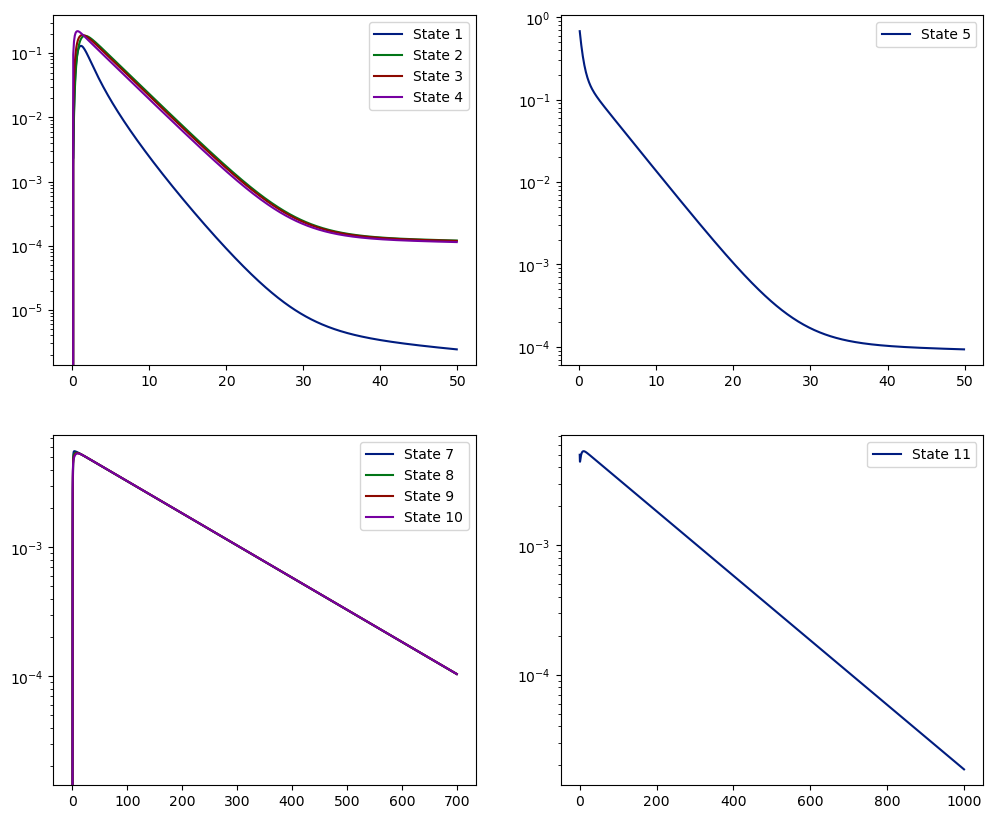

In [123]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(ts[1:500], sojourn_dist[1:500,0] / ts[1:500], label="State 1")
ax[0,0].plot(ts[:500], sojourn_dist[:500,1], label="State 2")
ax[0,0].plot(ts[:500], sojourn_dist[:500,2], label="State 3")
ax[0,0].plot(ts[:500], sojourn_dist[:500,3], label="State 4")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(ts[1:500], sojourn_dist[1:500,4], label="State 5")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(ts[:7000], sojourn_dist[:7000,5], label="State 7")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,6], label="State 8")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,7], label="State 9")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,8], label="State 10")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(ts, sojourn_dist[:,9], label="State 11")
ax[1,1].set_yscale('log')
ax[1,1].legend()
plt.show()

In [124]:
sojourn_dist = np.zeros((10_000, 10))
ts = np.linspace(0,1000,num=10_000)
Q = LCC_Q_no_open(params, sim.V[100], sim.CaSS[100].mean())
expQ = expm((ts[1]-ts[0])*Q)
sojourn_dist[0, :] = np.clip(-Q @ np.ones(10), a_min=0.0, a_max=np.inf)
for i, t in enumerate(ts[1:]):
    sojourn_dist[i+1, :] = np.clip(expQ @ sojourn_dist[i, :], a_min=0.0, a_max=np.inf)

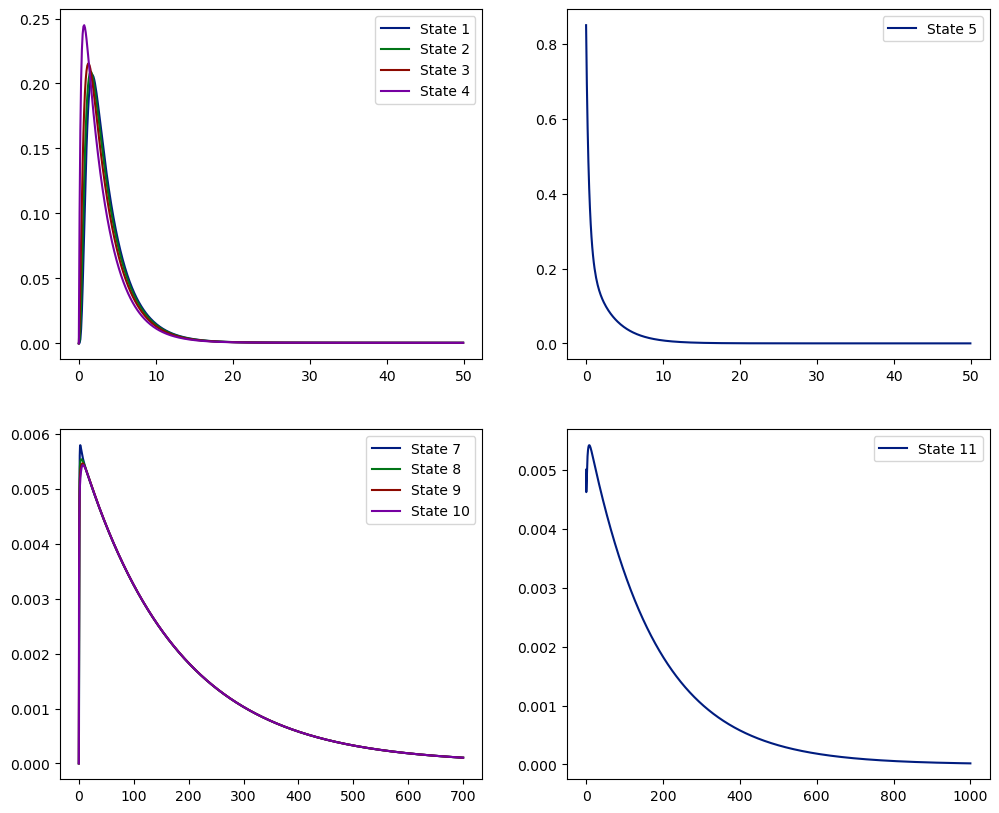

In [125]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(ts[:500], sojourn_dist[:500,0], label="State 1")
ax[0,0].plot(ts[:500], sojourn_dist[:500,1], label="State 2")
ax[0,0].plot(ts[:500], sojourn_dist[:500,2], label="State 3")
ax[0,0].plot(ts[:500], sojourn_dist[:500,3], label="State 4")
ax[0,0].legend()

ax[0,1].plot(ts[:500], sojourn_dist[:500,4], label="State 5")
ax[0,1].legend()

ax[1,0].plot(ts[:7000], sojourn_dist[:7000,5], label="State 7")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,6], label="State 8")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,7], label="State 9")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,8], label="State 10")
ax[1,0].legend()

ax[1,1].plot(ts, sojourn_dist[:,9], label="State 11")
ax[1,1].legend()
plt.show()

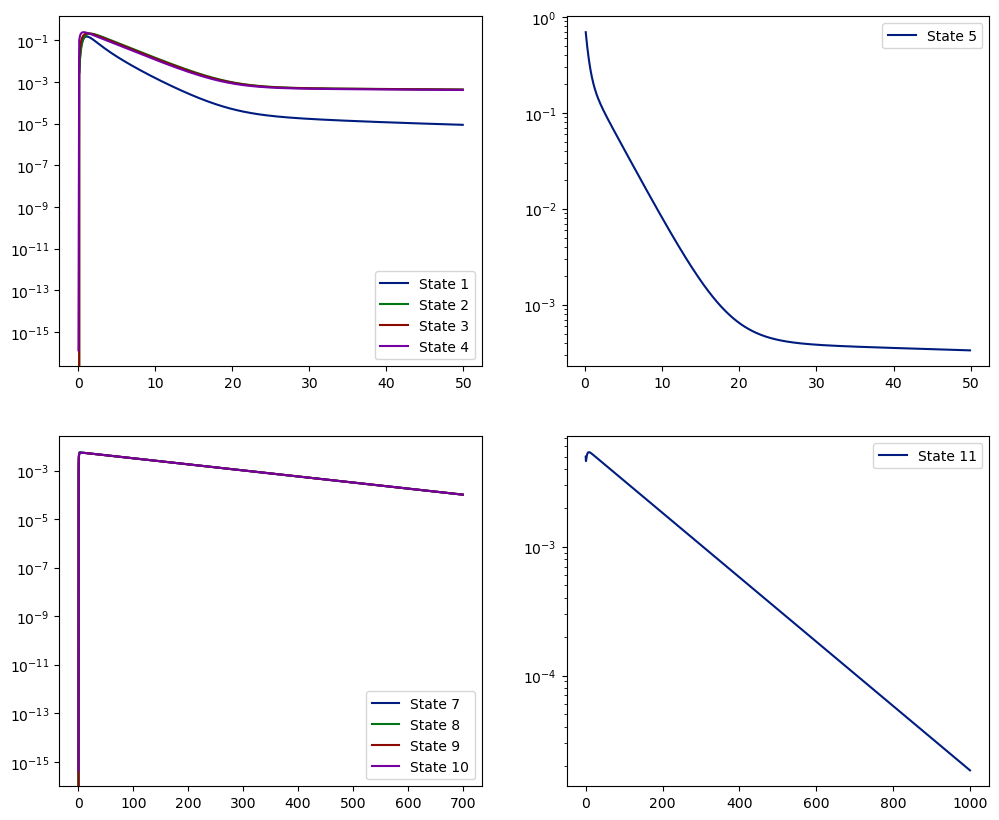

In [126]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(ts[1:500], sojourn_dist[1:500,0] / ts[1:500], label="State 1")
ax[0,0].plot(ts[:500], sojourn_dist[:500,1], label="State 2")
ax[0,0].plot(ts[:500], sojourn_dist[:500,2], label="State 3")
ax[0,0].plot(ts[:500], sojourn_dist[:500,3], label="State 4")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(ts[1:500], sojourn_dist[1:500,4], label="State 5")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(ts[:7000], sojourn_dist[:7000,5], label="State 7")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,6], label="State 8")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,7], label="State 9")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,8], label="State 10")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(ts, sojourn_dist[:,9], label="State 11")
ax[1,1].set_yscale('log')
ax[1,1].legend()
plt.show()

In [127]:
sojourn_dist = np.zeros((10_000, 10))
ts = np.linspace(0,1000,num=10_000)
Q = LCC_Q_no_open(params, sim.V[10], sim.CaSS[10].mean())
expQ = expm((ts[1]-ts[0])*Q)
sojourn_dist[0, :] = np.clip(-Q @ np.ones(10), a_min=0.0, a_max=np.inf)
for i, t in enumerate(ts[1:]):
    sojourn_dist[i+1, :] = np.clip(expQ @ sojourn_dist[i, :], a_min=0.0, a_max=np.inf)

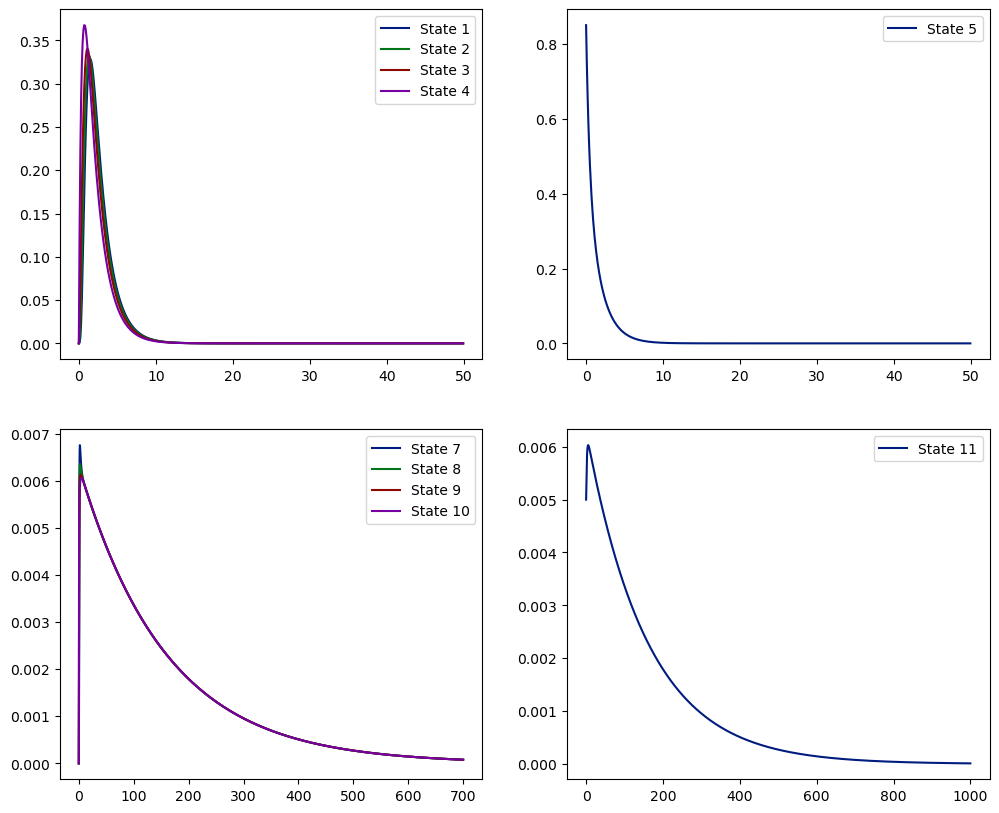

In [128]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(ts[:500], sojourn_dist[:500,0], label="State 1")
ax[0,0].plot(ts[:500], sojourn_dist[:500,1], label="State 2")
ax[0,0].plot(ts[:500], sojourn_dist[:500,2], label="State 3")
ax[0,0].plot(ts[:500], sojourn_dist[:500,3], label="State 4")
ax[0,0].legend()

ax[0,1].plot(ts[:500], sojourn_dist[:500,4], label="State 5")
ax[0,1].legend()

ax[1,0].plot(ts[:7000], sojourn_dist[:7000,5], label="State 7")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,6], label="State 8")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,7], label="State 9")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,8], label="State 10")
ax[1,0].legend()

ax[1,1].plot(ts, sojourn_dist[:,9], label="State 11")
ax[1,1].legend()
plt.show()

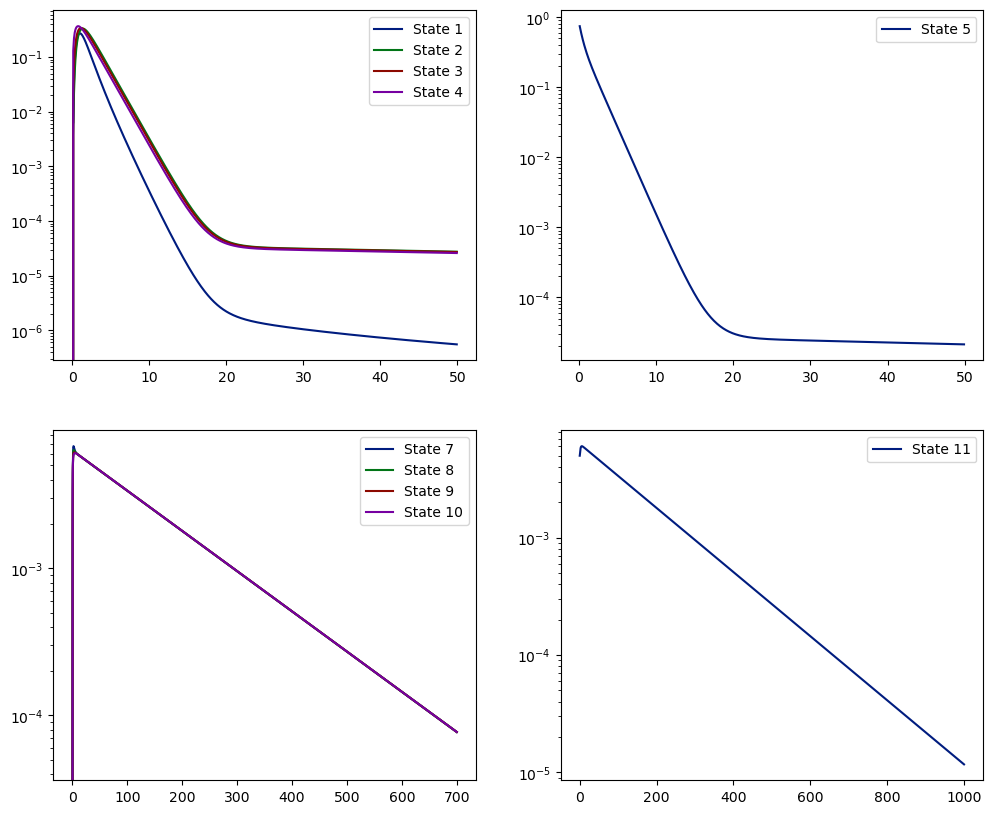

In [130]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(ts[1:500], sojourn_dist[1:500,0] / ts[1:500], label="State 1")
ax[0,0].plot(ts[:500], sojourn_dist[:500,1], label="State 2")
ax[0,0].plot(ts[:500], sojourn_dist[:500,2], label="State 3")
ax[0,0].plot(ts[:500], sojourn_dist[:500,3], label="State 4")
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[0,1].plot(ts[1:500], sojourn_dist[1:500,4], label="State 5")
ax[0,1].set_yscale('log')
ax[0,1].legend()

ax[1,0].plot(ts[:7000], sojourn_dist[:7000,5], label="State 7")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,6], label="State 8")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,7], label="State 9")
ax[1,0].plot(ts[:7000], sojourn_dist[:7000,8], label="State 10")
ax[1,0].set_yscale('log')
ax[1,0].legend()

ax[1,1].plot(ts, sojourn_dist[:,9], label="State 11")
ax[1,1].set_yscale('log')
ax[1,1].legend()
plt.show()

In [133]:
sojourn_dist = np.zeros((10_000, 10))
sojourn_dist_lowCa = np.zeros((10_000, 10))
sojourn_dist_highCa = np.zeros((10_000, 10))
ts = np.linspace(0,1000,num=10_000)
Q = LCC_Q_no_open(params, sim.V[100], sim.CaSS[100].mean())
Qlow = LCC_Q_no_open(params, sim.V[100], 1e-4)
Qhigh = LCC_Q_no_open(params, sim.V[100], 0.08)
expQ = expm((ts[1]-ts[0])*Q)
expQlow = expm((ts[1]-ts[0])*Qlow)
expQhigh = expm((ts[1]-ts[0])*Qhigh)
sojourn_dist[0, :] = np.clip(-Q @ np.ones(10), a_min=0.0, a_max=np.inf)
sojourn_dist_lowCa[0, :] = np.clip(-Qlow @ np.ones(10), a_min=0.0, a_max=np.inf)
sojourn_dist_highCa[0, :] = np.clip(-Qhigh @ np.ones(10), a_min=0.0, a_max=np.inf)
for i, t in enumerate(ts[1:]):
    sojourn_dist[i+1, :] = np.clip(expQ @ sojourn_dist[i, :], a_min=0.0, a_max=np.inf)
    sojourn_dist_lowCa[i+1, :] = np.clip(expQlow @ sojourn_dist_lowCa[i, :], a_min=0.0, a_max=np.inf)
    sojourn_dist_highCa[i+1, :] = np.clip(expQhigh @ sojourn_dist_highCa[i, :], a_min=0.0, a_max=np.inf)

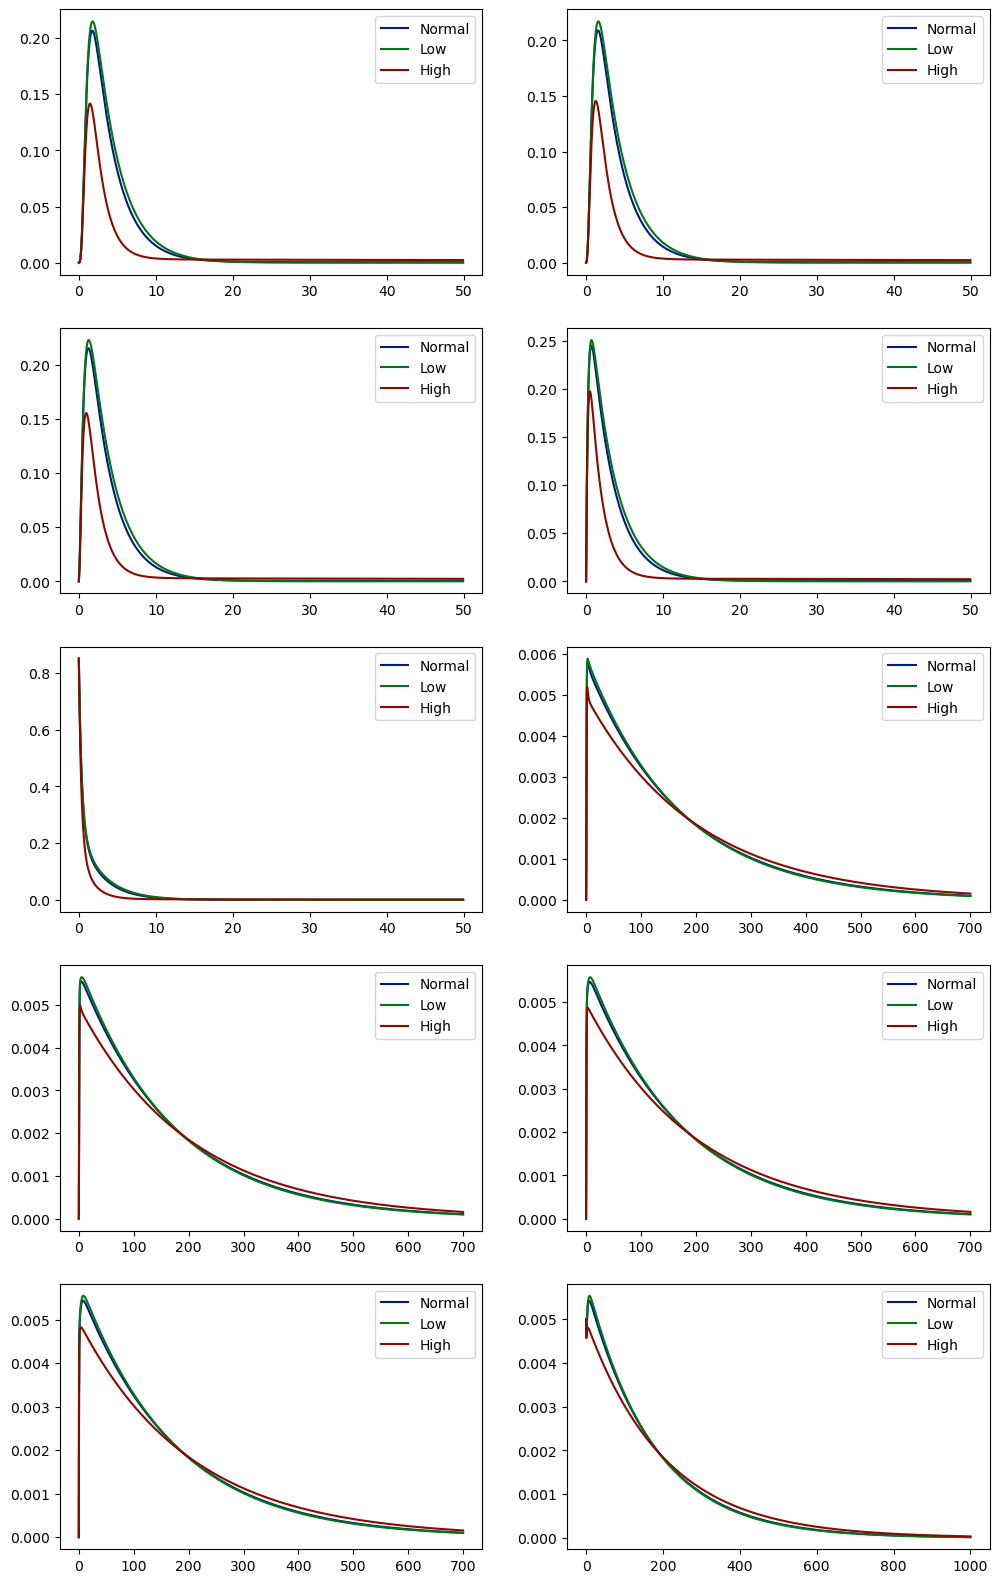

In [135]:
fig, ax = plt.subplots(5,2, figsize=(12,20))
ax[0,0].plot(ts[:500], sojourn_dist[:500,0], label="Normal")
ax[0,0].plot(ts[:500], sojourn_dist_lowCa[:500,0], label="Low")
ax[0,0].plot(ts[:500], sojourn_dist_highCa[:500,0], label="High")
ax[0,0].legend()

ax[0,1].plot(ts[:500], sojourn_dist[:500,1], label="Normal")
ax[0,1].plot(ts[:500], sojourn_dist_lowCa[:500,1], label="Low")
ax[0,1].plot(ts[:500], sojourn_dist_highCa[:500,1], label="High")
ax[0,1].legend()

ax[1,0].plot(ts[:500], sojourn_dist[:500,2], label="Normal")
ax[1,0].plot(ts[:500], sojourn_dist_lowCa[:500,2], label="Low")
ax[1,0].plot(ts[:500], sojourn_dist_highCa[:500,2], label="High")
ax[1,0].legend()

ax[1,1].plot(ts[:500], sojourn_dist[:500,3], label="Normal")
ax[1,1].plot(ts[:500], sojourn_dist_lowCa[:500,3], label="Low")
ax[1,1].plot(ts[:500], sojourn_dist_highCa[:500,3], label="High")
ax[1,1].legend()

ax[2,0].plot(ts[:500], sojourn_dist[:500,4], label="Normal")
ax[2,0].plot(ts[:500], sojourn_dist_lowCa[:500,4], label="Low")
ax[2,0].plot(ts[:500], sojourn_dist_highCa[:500,4], label="High")
ax[2,0].legend()

ax[2,1].plot(ts[:7000], sojourn_dist[:7000,5], label="Normal")
ax[2,1].plot(ts[:7000], sojourn_dist_lowCa[:7000,5], label="Low")
ax[2,1].plot(ts[:7000], sojourn_dist_highCa[:7000,5], label="High")
ax[2,1].legend()

ax[3,0].plot(ts[:7000], sojourn_dist[:7000,6], label="Normal")
ax[3,0].plot(ts[:7000], sojourn_dist_lowCa[:7000,6], label="Low")
ax[3,0].plot(ts[:7000], sojourn_dist_highCa[:7000,6], label="High")
ax[3,0].legend()

ax[3,1].plot(ts[:7000], sojourn_dist[:7000,7], label="Normal")
ax[3,1].plot(ts[:7000], sojourn_dist_lowCa[:7000,7], label="Low")
ax[3,1].plot(ts[:7000], sojourn_dist_highCa[:7000,7], label="High")
ax[3,1].legend()

ax[4,0].plot(ts[:7000], sojourn_dist[:7000,8], label="Normal")
ax[4,0].plot(ts[:7000], sojourn_dist_lowCa[:7000,8], label="Low")
ax[4,0].plot(ts[:7000], sojourn_dist_highCa[:7000,8], label="High")
ax[4,0].legend()

ax[4,1].plot(ts, sojourn_dist[:,9], label="Normal")
ax[4,1].plot(ts, sojourn_dist_lowCa[:,9], label="Low")
ax[4,1].plot(ts, sojourn_dist_highCa[:,9], label="High")
ax[4,1].legend()

plt.show()

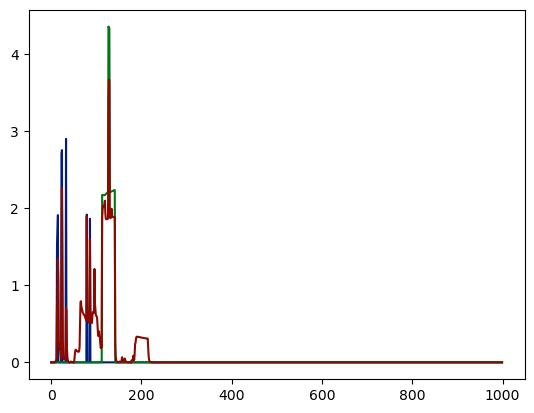

In [82]:
plt.plot(JLCC(sim, params)[:, 0,0])
plt.plot(Jrel(sim, params)[:, 0,0])
plt.plot(Jxfer(sim, params)[:, 0,0])
plt.show()

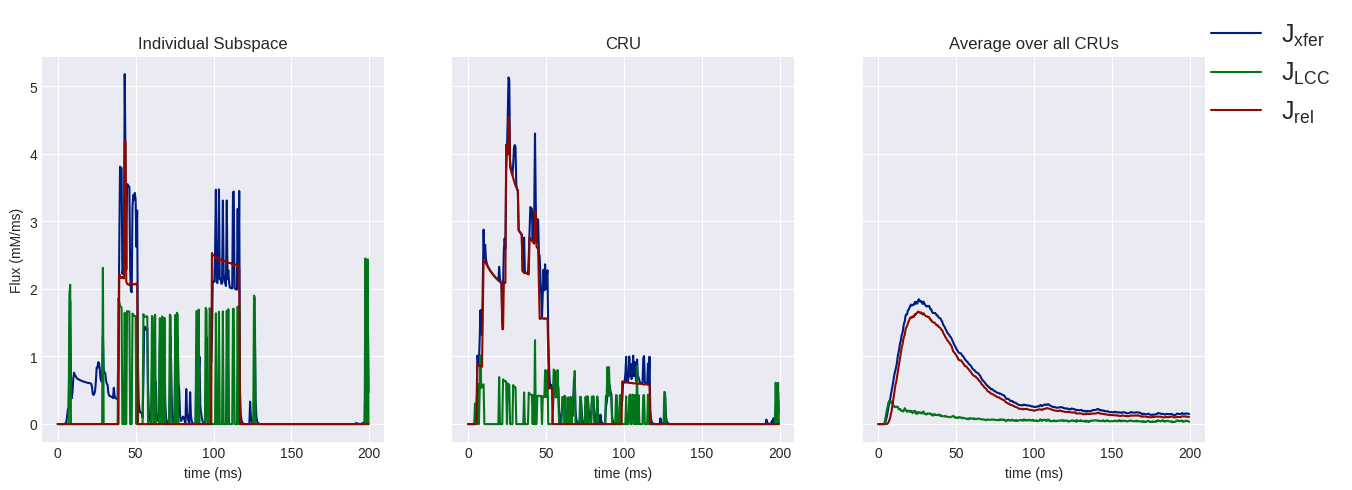

In [48]:
fig, ax = plt.subplots(1,3,figsize=(15,5), sharey=True)
ax[0].plot(sim.t[:400], Jxfer(sim, params)[:400, 0,1], label=r"$\mathregular{J_{xfer}}$")
ax[0].plot(sim.t[:400], JLCC(sim, params)[:400, 0,1], label=r"$\mathregular{J_{LCC}}$")
ax[0].plot(sim.t[:400], Jrel(sim, params)[:400, 0,1], label=r"$\mathregular{J_{rel}}$")
ax[0].set_xlabel("time (ms)")
ax[0].set_ylabel("Flux (mM/ms)")
ax[0].set_title("Individual Subspace")

ax[1].plot(sim.t[:400], Jxfer(sim, params)[:400, 0].mean(axis=1))
ax[1].plot(sim.t[:400], JLCC(sim, params)[:400, 0].mean(axis=1))
ax[1].plot(sim.t[:400], Jrel(sim, params)[:400, 0].mean(axis=1))
ax[1].set_xlabel("time (ms)")
ax[1].set_title("CRU")

ax[2].plot(sim.t[:400], Jxfer(sim, params)[:400].mean(axis=(1,2)))
ax[2].plot(sim.t[:400], JLCC(sim, params)[:400].mean(axis=(1,2)))
ax[2].plot(sim.t[:400], Jrel(sim, params)[:400].mean(axis=(1,2)))
ax[2].set_xlabel("time (ms)")
ax[2].set_title("Average over all CRUs")

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=18)

fig.savefig("/home/luke/PhD-Writing/work/images/calcium-fluxes.pdf", bbox_inches='tight')

plt.show()

/tmp/ipykernel_42649/1032766700.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.plot(sim.t, sim.Ito2 / sim.ICaL)
/tmp/ipykernel_42649/1032766700.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(sim.t, sim.Ito2 / sim.ICaL)


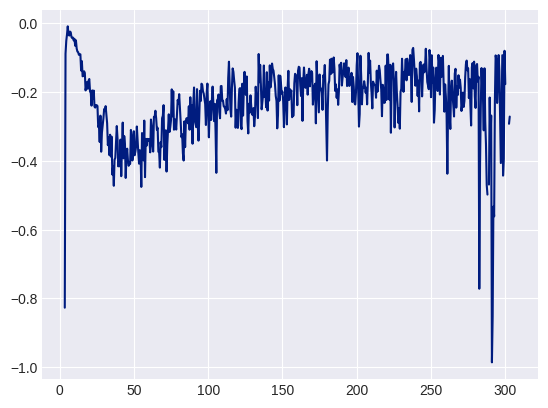

In [69]:
#plt.plot(sim.t, Jxfer(sim, params)[400:800].mean(axis=(1,2)))
plt.plot(sim.t, sim.Ito2 / sim.ICaL)
#plt.plot(sim.t, sim.ICaL)
#plt.plot(sim.t, Jrel(sim, params)[400:800].mean(axis=(1,2)))
#plt.xlabel("time (ms)")
#plt.title("Average over all CRUs")
plt.show()

In [12]:
sim.CaSS.max()

0.07936010767589777

In [27]:
CaSS_vals = np.linspace(start=1e-4, stop=8e-2, num=1000)
RyR_eigvals = np.zeros((1000, 6))
RyR_eigvecs = np.zeros((1000, 6, 6))
for i in range(1000):
    eigs = np.linalg.eig(RyR_Q(params, CaSS_vals[i]).T)
    sorted_idx = np.argsort(eigs.eigenvalues)
    RyR_eigvals[i, :] = eigs.eigenvalues[sorted_idx]
    RyR_eigvecs[i, :, :] = eigs.eigenvectors[:, sorted_idx]

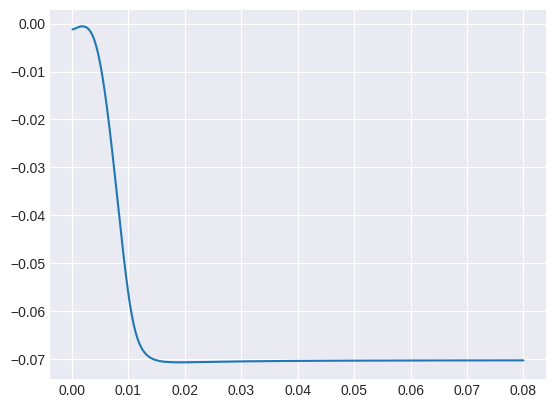

In [160]:
plt.plot(CaSS_vals, RyR_eigvals[:, -2])
plt.show()

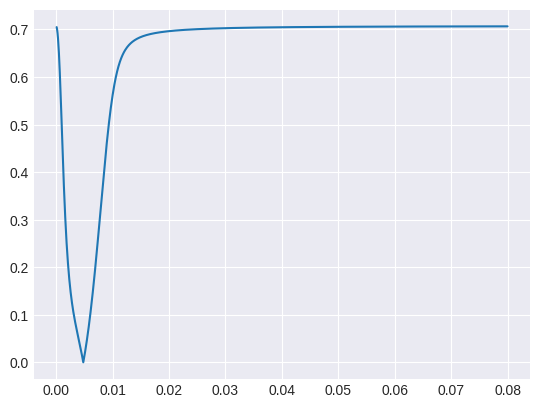

In [165]:
plt.plot(CaSS_vals, np.abs(RyR_eigvecs[:, 3, -2] + RyR_eigvecs[:, 4, -2]))
plt.show()

In [45]:
RyR_eigvals[:, -3].argmax()

112

In [130]:
LCC_eigvals = np.zeros((1000, 12))
LCC_eigvecs = np.zeros((1000, 12, 12))
LCC_left_eigvecs = np.zeros((1000, 12, 12))
for i in range(1000):
    eigs = np.linalg.eig(LCC_Q(params, sim.V[i], sim.CaSS[i].mean()).T)
    left_eigs = np.linalg.eig(LCC_Q(params, sim.V[i], sim.CaSS[i].mean()))

    sorted_idx = np.argsort(eigs.eigenvalues)
    sorted_idx_left = np.argsort(left_eigs.eigenvalues)

    LCC_eigvals[i, :] = eigs.eigenvalues[sorted_idx]
    LCC_eigvecs[i, :, :] = eigs.eigenvectors[:, sorted_idx]
    LCC_left_eigvecs[i, :, :] = left_eigs.eigenvectors[:, sorted_idx_left]

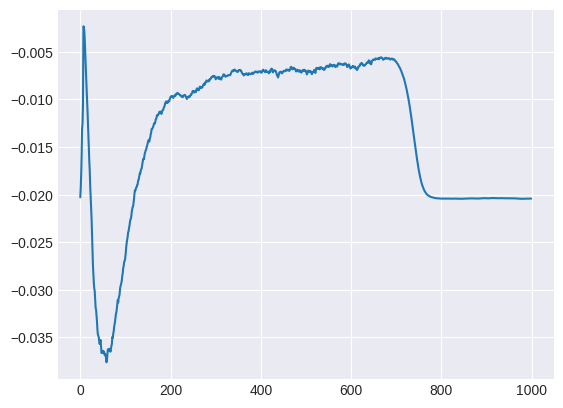

In [131]:
plt.plot(LCC_eigvals[:, -2])
plt.show()

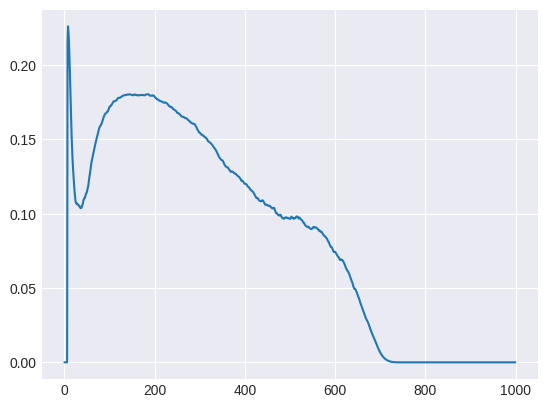

In [132]:
plt.plot(np.abs(LCC_eigvecs[:, 5, -2]))
plt.show()

In [133]:
LCC_left_eigvecs

array([[[ 6.26606383e-09,  7.13509657e-07,  5.61457759e-12, ...,
         -2.89942512e-09, -1.33699462e-03,  2.88675135e-01],
        [-7.01016975e-07, -5.94488378e-05, -2.75831248e-10, ...,
          3.88106567e-10, -1.33645660e-03,  2.88675135e-01],
        [ 7.85377833e-05,  4.39001560e-03,  7.11447313e-09, ...,
          1.21881205e-07, -1.33565150e-03,  2.88675135e-01],
        ...,
        [ 3.37418966e-07,  1.03894814e-05,  3.46350273e-02, ...,
          1.40429157e-09,  4.08136503e-01,  2.88675135e-01],
        [-1.61760103e-05,  9.40840179e-06, -9.96838242e-01, ...,
          6.94540597e-08,  4.08212233e-01,  2.88675135e-01],
        [ 5.92154463e-07, -4.66842949e-07,  7.15016370e-02, ...,
          9.70654771e-08,  4.09398219e-01,  2.88675135e-01]],

       [[ 6.49681188e-08,  4.22490465e-06,  6.74182034e-11, ...,
         -3.14122980e-08, -1.44428643e-03,  2.88675135e-01],
        [-4.03935800e-06, -1.94758206e-04, -1.72190902e-09, ...,
          2.75358682e-10, -1.44341776e

In [134]:
LCC_states = np.zeros((*sim.LCC[:1000].shape, 12))
LCC_states[..., 0] = sim.LCC[:1000] == 1
LCC_states[..., 1] = sim.LCC[:1000] == 2
LCC_states[..., 2] = sim.LCC[:1000] == 3
LCC_states[..., 3] = sim.LCC[:1000] == 4
LCC_states[..., 4] = sim.LCC[:1000] == 5
LCC_states[..., 5] = sim.LCC[:1000] == 6
LCC_states[..., 6] = sim.LCC[:1000] == 7
LCC_states[..., 7] = sim.LCC[:1000] == 8
LCC_states[..., 8] = sim.LCC[:1000] == 9
LCC_states[..., 9] = sim.LCC[:1000] == 10
LCC_states[..., 10] = sim.LCC[:1000] == 11
LCC_states[..., 11] = sim.LCC[:1000] == 12

In [135]:
LCC_props = LCC_states.mean(axis=(1,2))

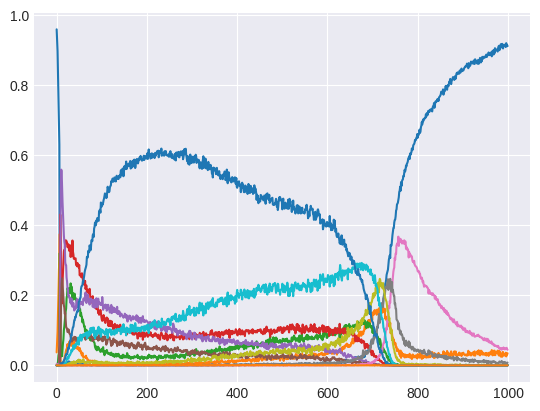

In [136]:
plt.plot(LCC_props)
plt.show()

In [141]:
LCC_left_eigvecs[0, :, -1]

array([0.28867513, 0.28867513, 0.28867513, 0.28867513, 0.28867513,
       0.28867513, 0.28867513, 0.28867513, 0.28867513, 0.28867513,
       0.28867513, 0.28867513])

In [143]:
coeffs = (LCC_left_eigvecs * np.sign(LCC_left_eigvecs[:, 0, :][:,np.newaxis,:]) * LCC_props[..., np.newaxis]).sum(axis=1)

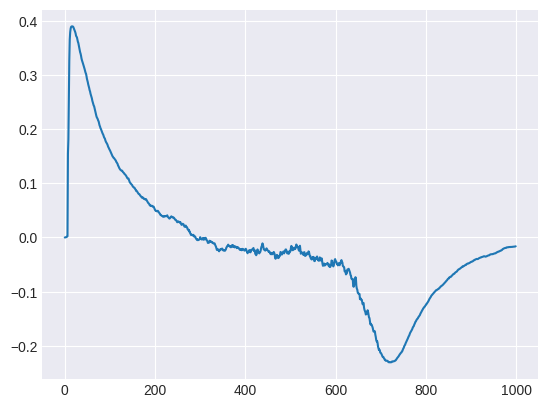

In [150]:
plt.plot(coeffs[:, -2])
plt.show()

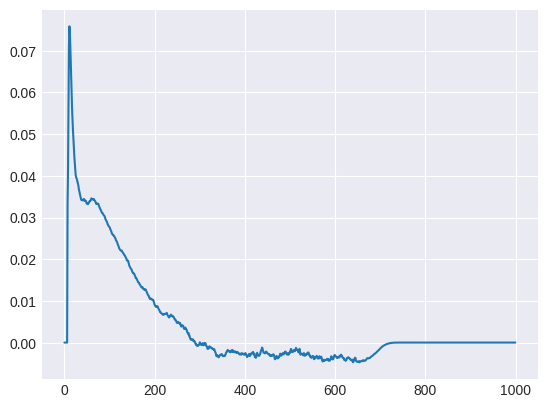

In [157]:
plt.plot(np.abs(LCC_eigvecs[:, 5, -2]) * coeffs[:, -2])
plt.show()

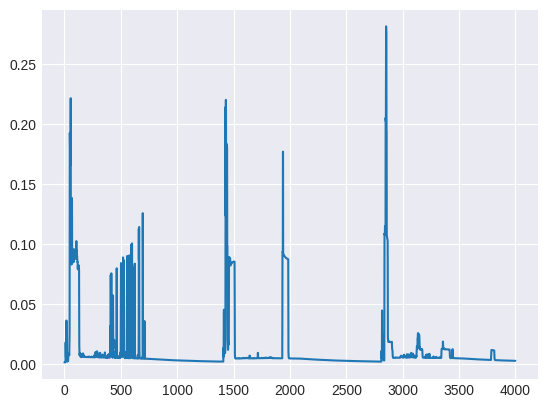

In [69]:
plt.plot(16*0.44*sim.CaSS[:, 0,0])
plt.show()

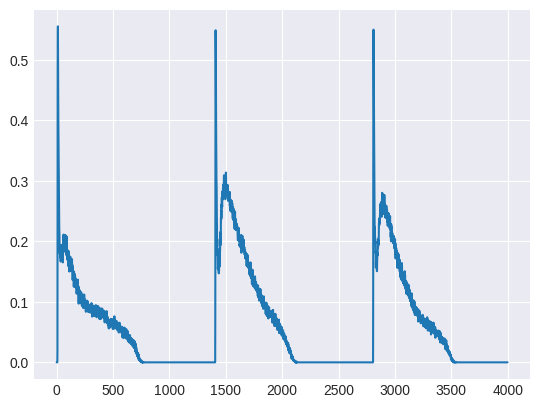

In [71]:
plt.plot((sim.LCC==5).mean(axis=(1,2)))
plt.show()

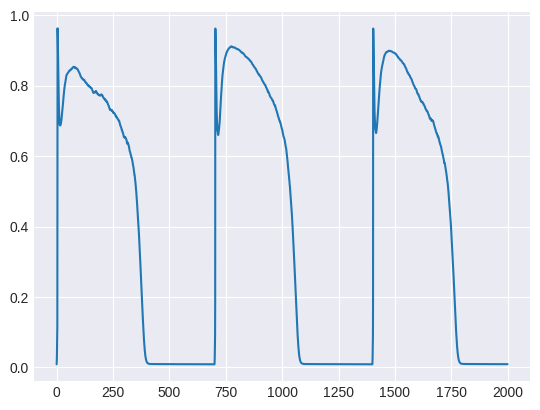

In [75]:
alpha = 2.0*np.exp(0.012*(sim.V-35))
beta = 0.0882 * np.exp(-0.05*(sim.V-35))
plt.plot(sim.t, alpha / (alpha + beta))
plt.show()

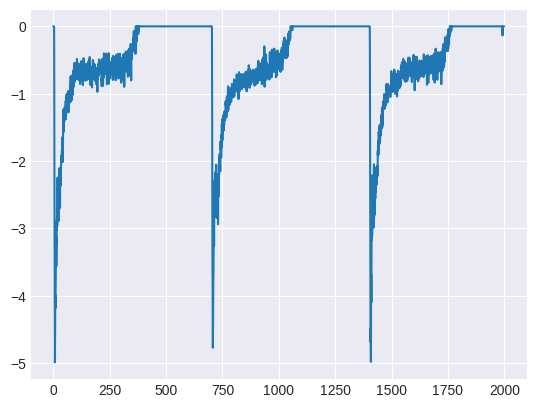

In [81]:
plt.plot(sim.t, sim.ICaL)
plt.show()

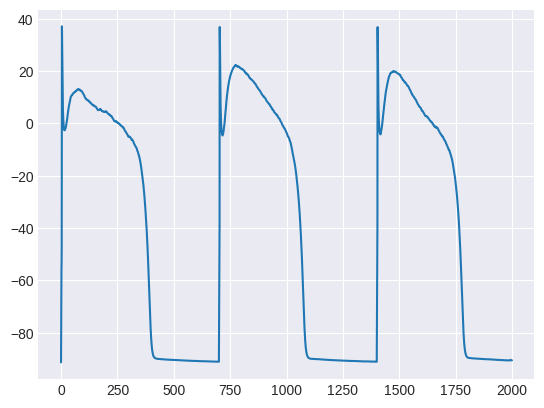

In [31]:
plt.plot(sim.t, sim.V)
plt.show()

In [32]:
Jxfer_ = Jxfer(sim, params)
JLCC_ = JLCC(sim, params)
Jrel_ = Jrel(sim, params)
Jiss_ = Jiss(sim, params)
betass = betaSS(sim, params)

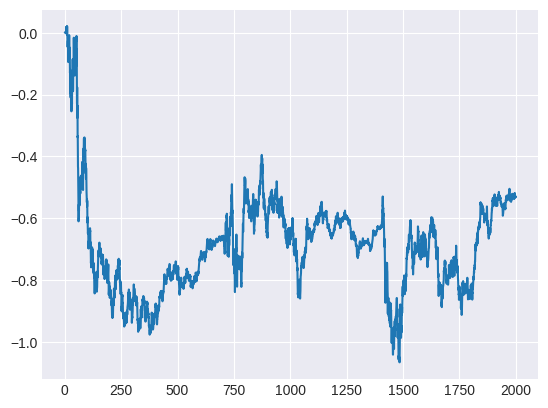

In [33]:
plt.plot(sim.t, sim.RyR_open_martingale[:, 0])
plt.show()

In [34]:
increments = sim.RyR_open_martingale[1:, 0] - sim.RyR_open_martingale[:-1, 0]

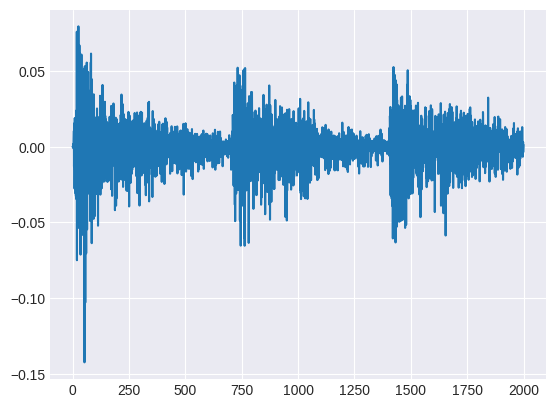

In [35]:
plt.plot(sim.t[:-1], increments)
plt.show()

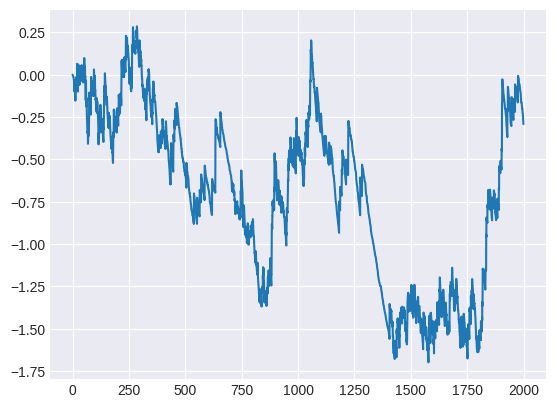

In [36]:
plt.plot(sim.t, sim.RyR_open_martingale_normalised[:, 0])
plt.show()

In [37]:
increments_n = sim.RyR_open_martingale_normalised[1:, 0] - sim.RyR_open_martingale_normalised[:-1, 0]

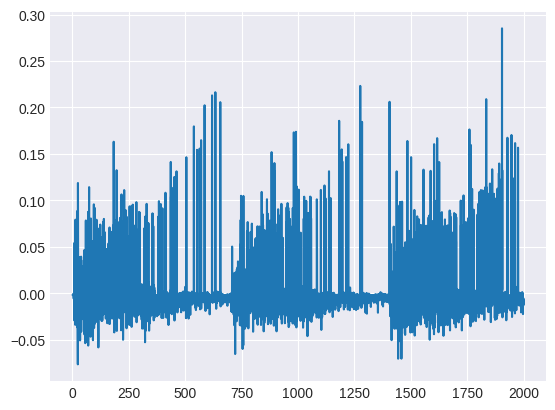

In [38]:
plt.plot(sim.t[1:], increments_n)
plt.show()

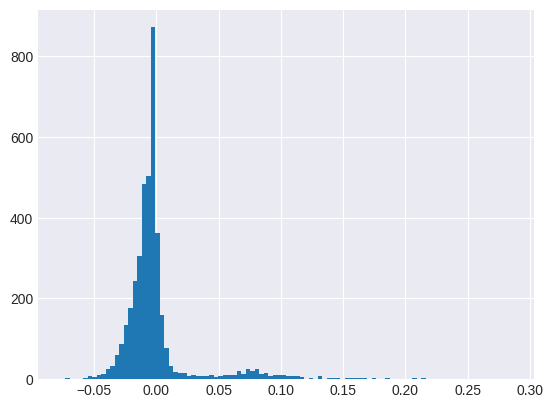

In [39]:
plt.hist(increments_n, bins=100)
plt.show()

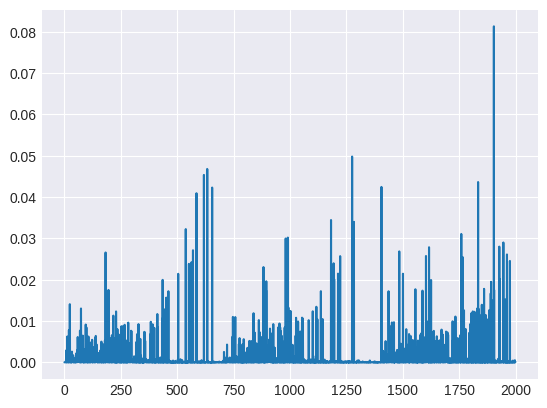

In [40]:
plt.plot(sim.t[:-1], increments_n**2)
plt.show()

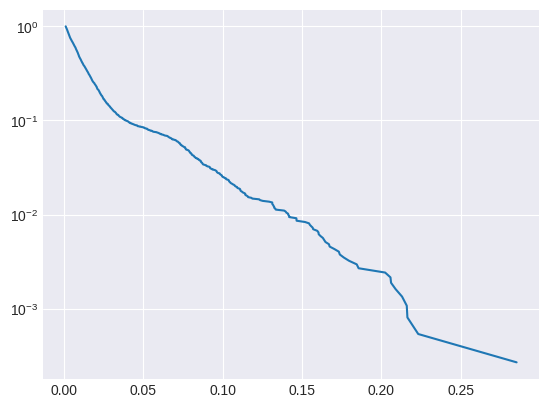

In [41]:
abs_jumps = np.abs(increments_n)[np.abs(increments_n) > 1e-3]
ps = np.arange(start=1, stop=abs_jumps.shape[0]+1) / abs_jumps.shape[0]
#coeffs = np.polyfit(np.log(np.sort(abs_jumps)), np.log(ps[::-1]), 1)
plt.plot(np.sort(abs_jumps), ps[::-1])
#plt.plot(np.sort(abs_jumps), np.exp(coeffs[1])*np.exp(coeffs[0]*np.log(np.sort(abs_jumps))))
#plt.xscale('log')
plt.yscale('log')
plt.show()

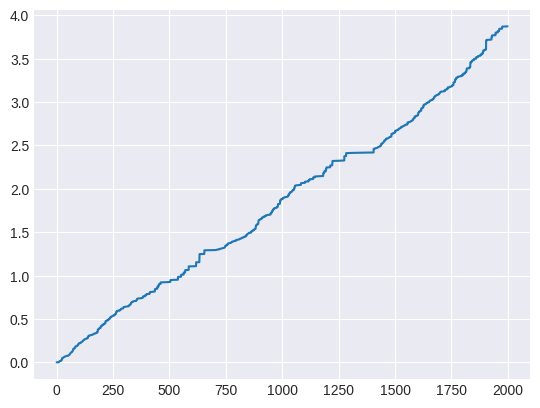

In [42]:
plt.plot(sim.t[:-1], (increments_n**2).cumsum())
plt.show()

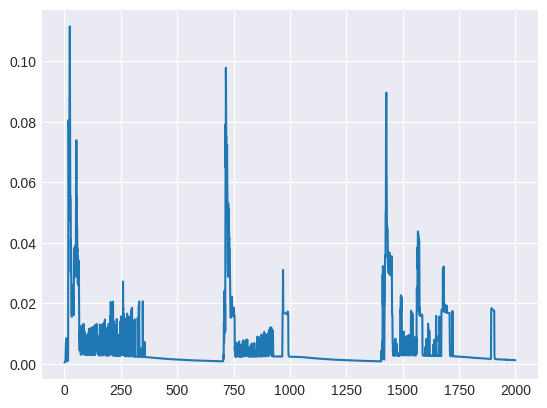

In [43]:
plt.plot(sim.t, sim.CaSS[:, 0].sum(axis=-1))
plt.show()

In [44]:
CaSSagg = sim.CaSS.sum(axis=-1)
dCaSSagg = CaSSagg[1:] - CaSSagg[:-1]

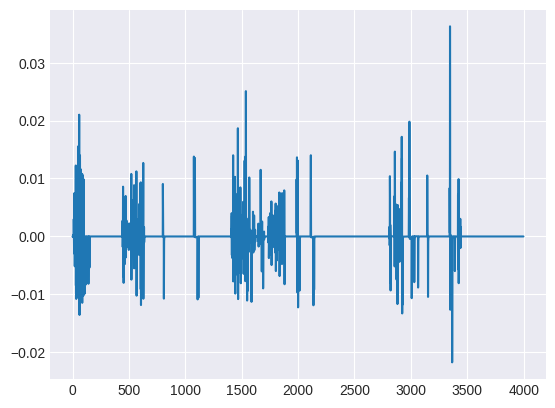

In [45]:
plt.plot(dCaSSagg[:,3])
plt.show()

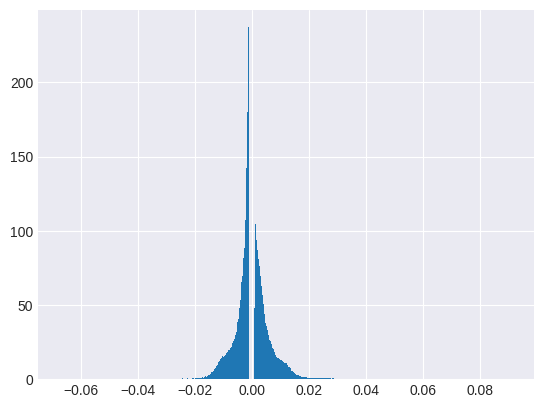

In [46]:
plt.hist(dCaSSagg[np.abs(dCaSSagg) > 1e-3], bins=1000, density=True)
plt.show()

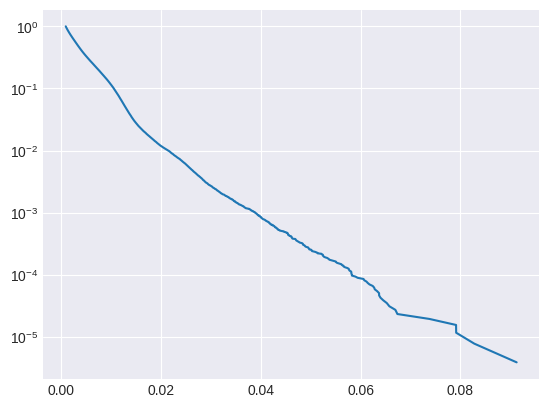

In [47]:
abs_jumps = np.abs(dCaSSagg)[np.abs(dCaSSagg) > 1e-3]
ps = np.arange(start=1, stop=abs_jumps.shape[0]+1) / abs_jumps.shape[0]
#coeffs = np.polyfit(np.log(np.sort(abs_jumps)), np.log(ps[::-1]), 1)
plt.plot(np.sort(abs_jumps), ps[::-1])
#plt.plot(np.sort(abs_jumps), np.exp(coeffs[1])*np.exp(coeffs[0]*np.log(np.sort(abs_jumps))))
#plt.xscale('log')
plt.yscale('log')
plt.show()
#print(coeffs[0]-1) 

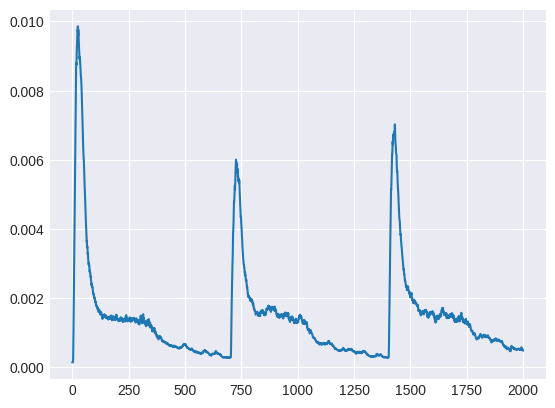

In [48]:
plt.plot(sim.t, sim.CaSS.mean(axis=(1,2)))
plt.show()

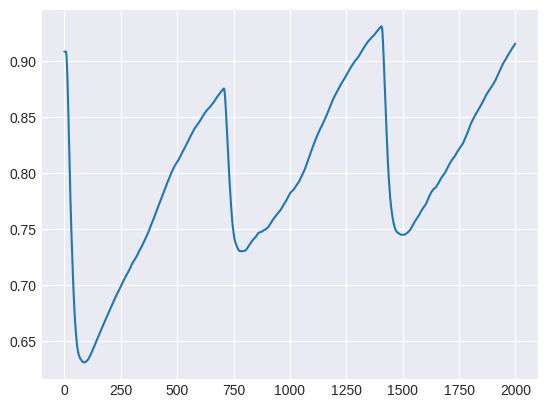

In [49]:
plt.plot(sim.t, sim.CaJSR.mean(axis=1))
plt.show()

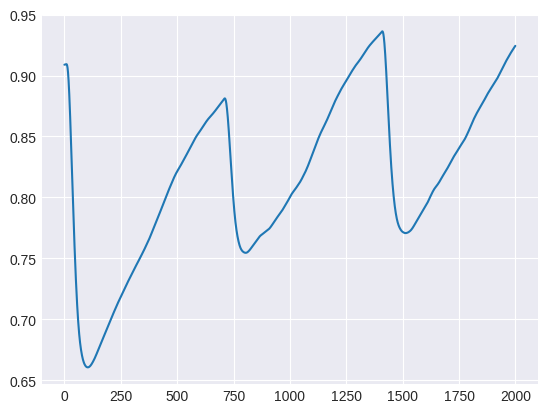

In [50]:
plt.plot(sim.t, sim.CaNSR)
plt.show()

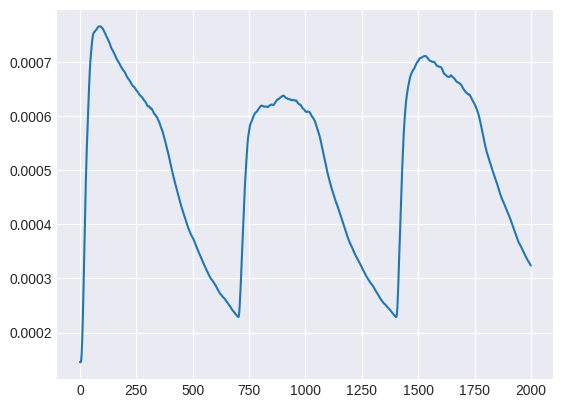

In [51]:
plt.plot(sim.t, sim.Cai)
plt.show()

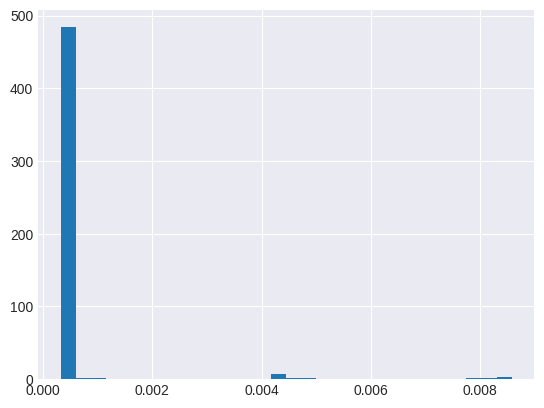

In [52]:
plt.hist(sim.CaSS[-1, :].mean(axis=1), bins=30)
plt.show()

In [55]:
CaSS_CRU = sim.CaSS.mean(axis=2)

In [164]:
params = GWParameters(NCaRU_sim=NCaRU_sim, riss=40.0) # Create parameters object using default values
Istim = lambda t: 35 if t < 2 else 0 # Stimulus function

model = GWModel(parameters=params, stimulus_fn=Istim, init_state=init_state) # Convenience wrapper around C++ function

In [165]:
%%time
sim = model.simulate(step_size=step_size, num_steps=num_steps, record_every=record_every)

CPU times: user 4min, sys: 5.19 s, total: 4min 5s
Wall time: 15.7 s


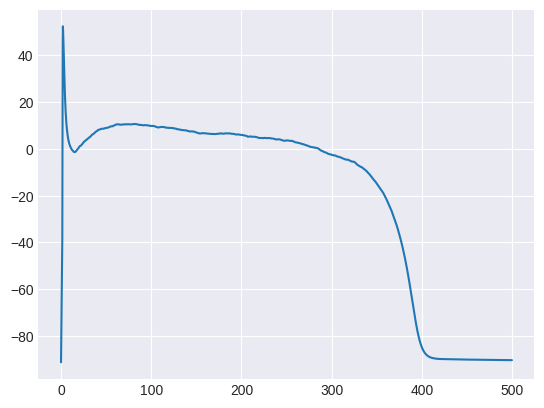

In [166]:
plt.plot(sim.t, sim.V)
plt.show()

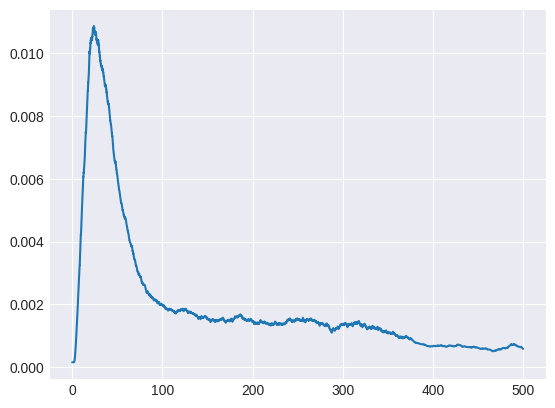

In [167]:
plt.plot(sim.t, sim.CaSS.mean(axis=(1,2)))
plt.show()

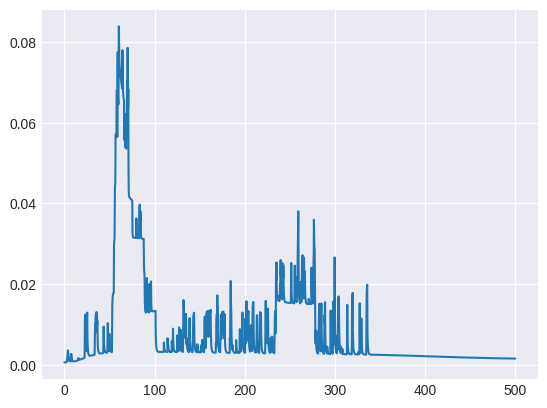

In [168]:
plt.plot(sim.t[::10], sim.CaSS[::10, 0].sum(axis=-1))
plt.show()

In [169]:
CaSSagg = sim.CaSS[::10, :].sum(axis=-1)
dCaSSagg = CaSSagg[1:] - CaSSagg[:-1]

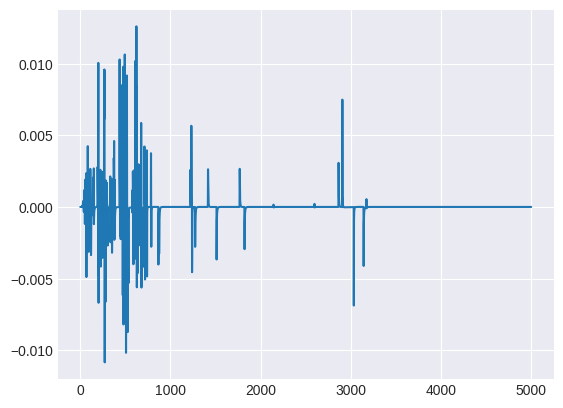

In [170]:
plt.plot(dCaSSagg[:,1])
plt.show()

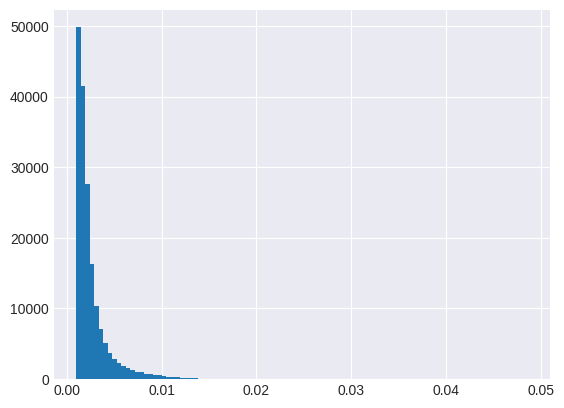

In [171]:
plt.hist(np.abs(dCaSSagg[np.abs(dCaSSagg) > 1e-3]), bins=100)
plt.show()

In [172]:
np.abs(dCaSSagg[np.abs(dCaSSagg) > 1e-3]).mean()

0.0025839986224581264

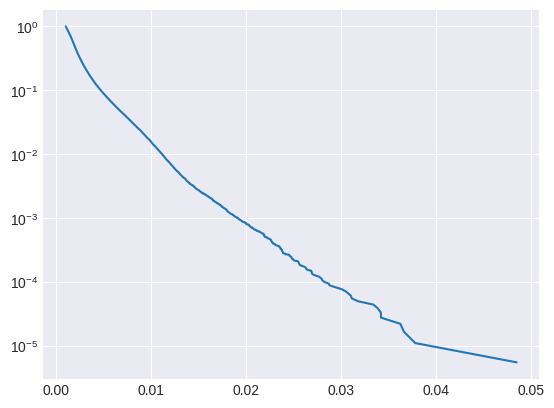

In [173]:
abs_jumps = np.abs(dCaSSagg)[np.abs(dCaSSagg) > 1e-3]
ps = np.arange(start=1, stop=abs_jumps.shape[0]+1) / abs_jumps.shape[0]
#coeffs = np.polyfit(np.log(np.sort(abs_jumps)), np.log(ps[::-1]), 1)
plt.plot(np.sort(abs_jumps), ps[::-1])
#plt.plot(np.sort(abs_jumps), np.exp(coeffs[1])*np.exp(coeffs[0]*np.log(np.sort(abs_jumps))))
#plt.xscale('log')
plt.yscale('log')
plt.show()
#print(coeffs[0]-1) 

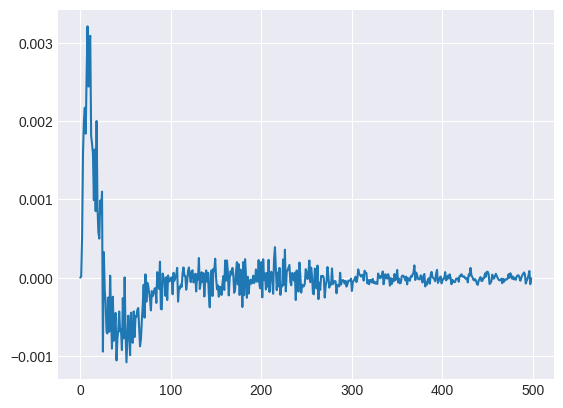

In [74]:
plt.plot(increments)
plt.show()

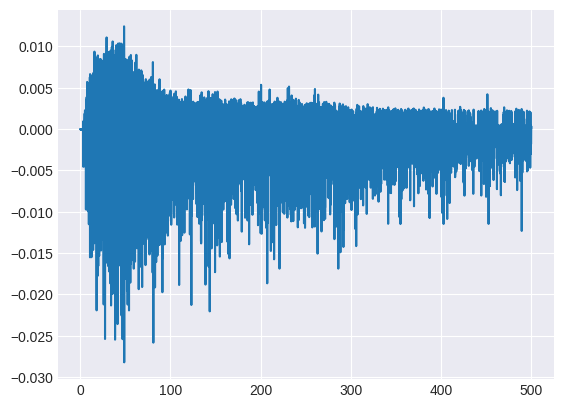

In [13]:
plt.plot(sim.t[:-1], increments) #/ (sim.CaSS[:-1] - sim.CaJSR[:-1, :, np.newaxis]).mean(axis=(1,2)))
plt.show()

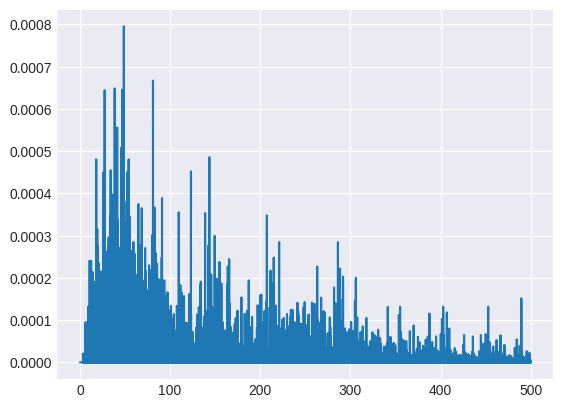

In [23]:
plt.plot(sim.t[:-1], increments**2)
plt.show()

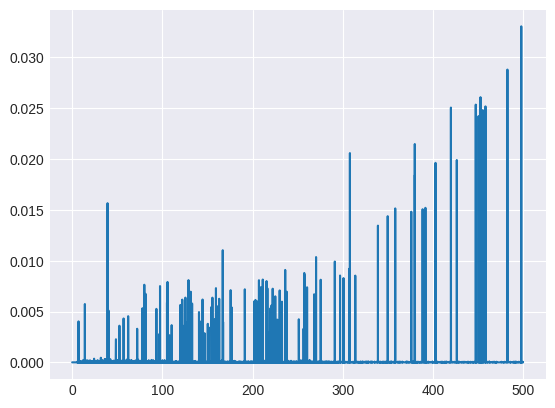

In [27]:
increments_n = sim.RyR_open_martingale_normalised[1:, 0] - sim.RyR_open_martingale_normalised[:-1, 0]
plt.plot(sim.t[1:], increments_n**2)
plt.show()

In [68]:
Jrel_ = Jrel(sim, params).mean(axis=(1,2))

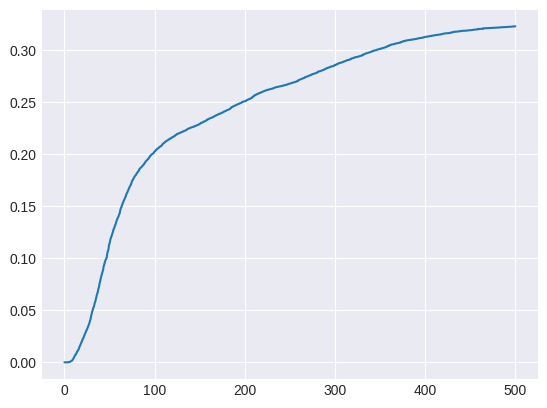

In [54]:
plt.plot(sim.t[:-1], (increments**2).cumsum())
plt.show()

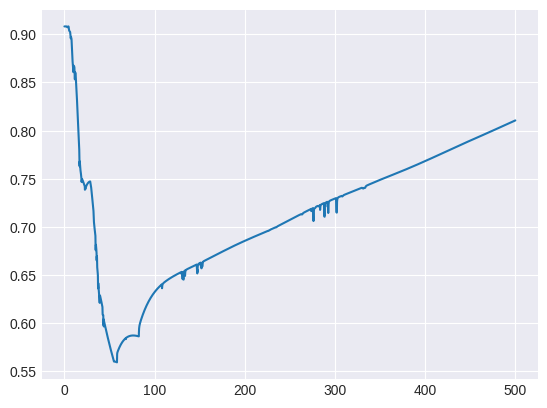

In [18]:
plt.plot(sim.t, (sim.CaJSR[:, 0] - sim.CaSS[:, 0, 0]) * )
plt.show()

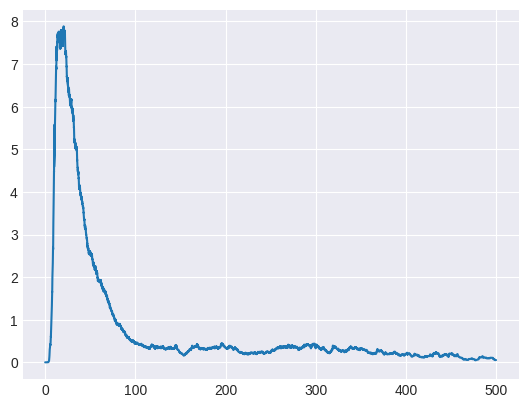

In [11]:
plt.plot(sim.t, np.mean(Jrel_ * Jxfer_, axis=(1,2)) - np.mean(Jrel_, axis=(1,2))*np.mean(Jxfer_, axis=(1,2)))
plt.show()

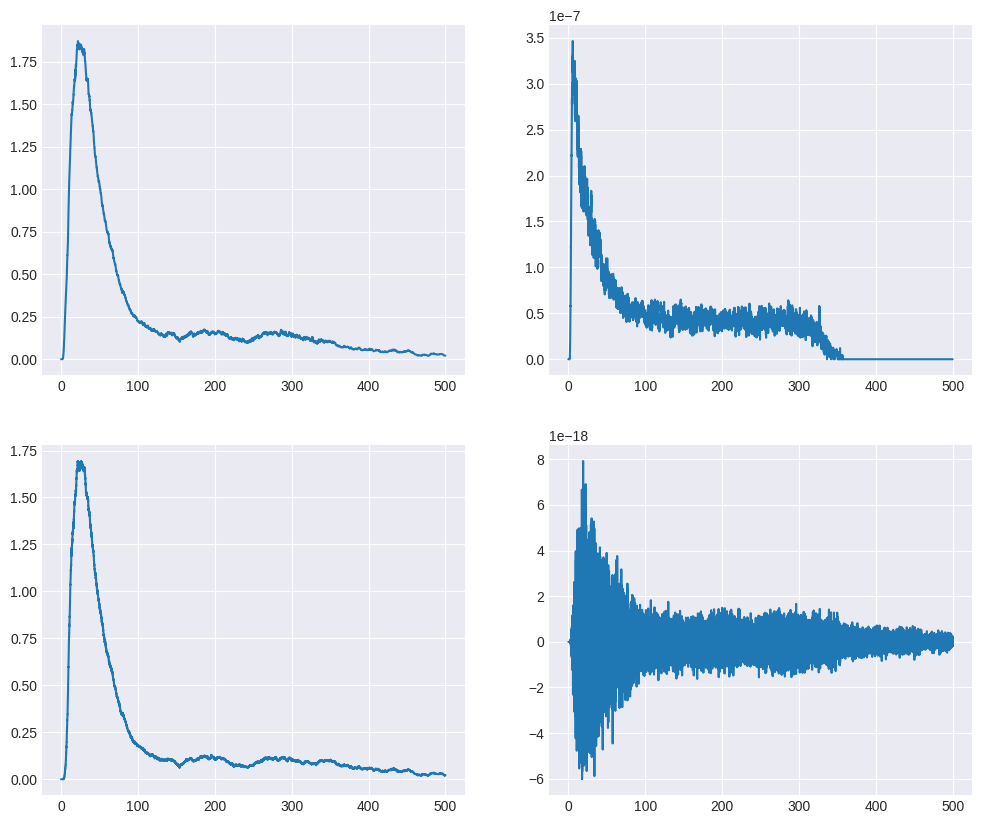

In [8]:
# means
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(sim.t, Jxfer_.mean(axis=(1,2)))
ax[0,1].plot(sim.t, JLCC_.mean(axis=(1,2)))
ax[1,0].plot(sim.t, Jrel_.mean(axis=(1,2)))
ax[1,1].plot(sim.t, Jiss_.mean(axis=(1,2)))
plt.show()

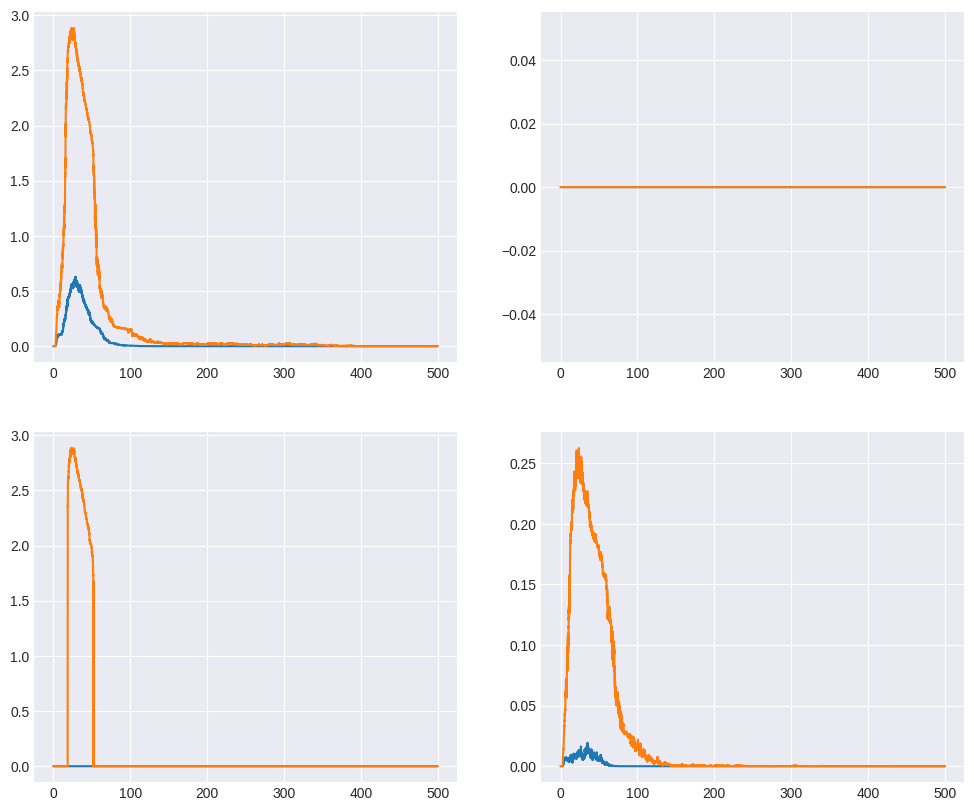

In [9]:
# median and quartiles
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(sim.t, np.median(Jxfer_, axis=(1,2)))
ax[0,0].plot(sim.t, np.quantile(Jxfer_, 0.75, axis=(1,2)))
ax[0,1].plot(sim.t, np.median(JLCC_, axis=(1,2)))
ax[0,1].plot(sim.t, np.quantile(JLCC_, 0.75, axis=(1,2)))
ax[1,0].plot(sim.t, np.median(Jrel_, axis=(1,2)))
ax[1,0].plot(sim.t, np.quantile(Jrel_, 0.75, axis=(1,2)))
ax[1,1].plot(sim.t, np.median(Jiss_, axis=(1,2)))
ax[1,1].plot(sim.t, np.quantile(Jiss_, 0.75, axis=(1,2)))
plt.show()

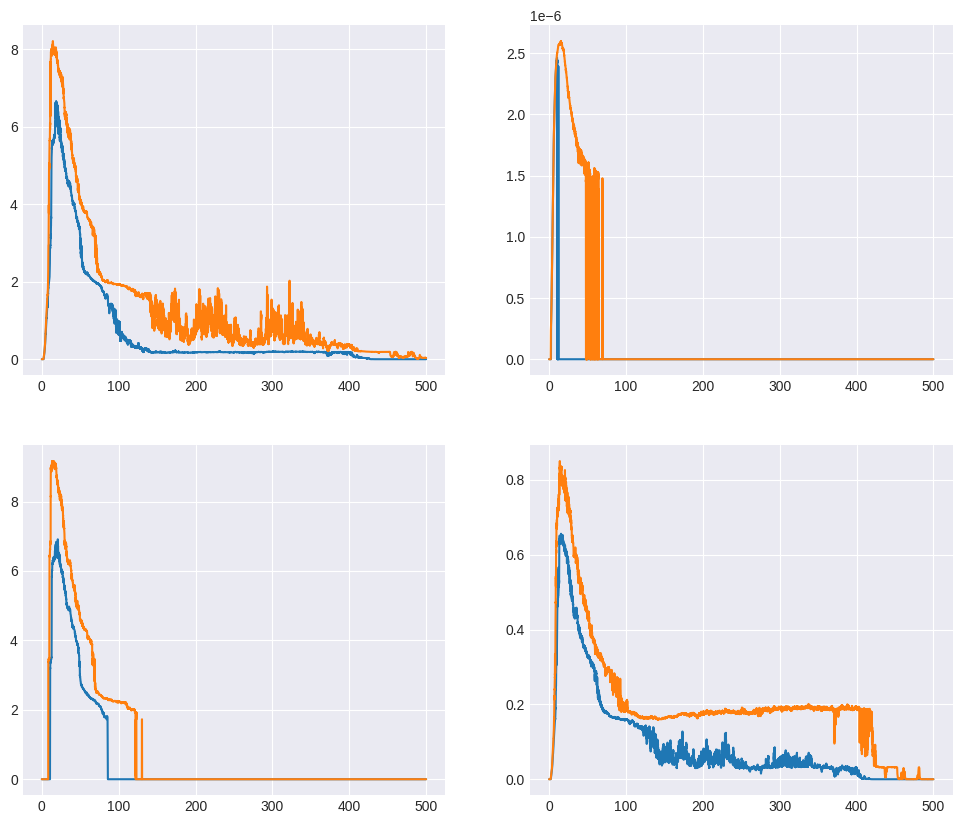

In [10]:
# 0.9 and 0.95 quantiles
fig, ax = plt.subplots(2,2, figsize=(12,10))
ax[0,0].plot(sim.t, np.quantile(Jxfer_, 0.9, axis=(1,2)))
ax[0,1].plot(sim.t, np.quantile(JLCC_, 0.9, axis=(1,2)))
ax[1,0].plot(sim.t, np.quantile(Jrel_, 0.9, axis=(1,2)))
ax[1,1].plot(sim.t, np.quantile(Jiss_, 0.9, axis=(1,2)))

ax[0,0].plot(sim.t, np.quantile(Jxfer_, 0.95, axis=(1,2)))
ax[0,1].plot(sim.t, np.quantile(JLCC_, 0.95, axis=(1,2)))
ax[1,0].plot(sim.t, np.quantile(Jrel_, 0.95, axis=(1,2)))
ax[1,1].plot(sim.t, np.quantile(Jiss_, 0.95, axis=(1,2)))
plt.show()

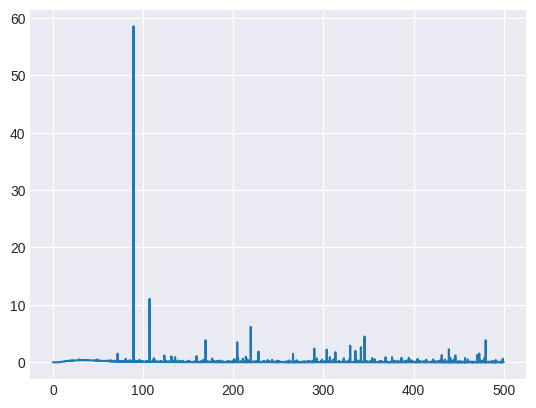

In [11]:
plt.plot(sim.t, (Jrel_ / Jxfer_).mean(axis=(1,2)))
plt.show()

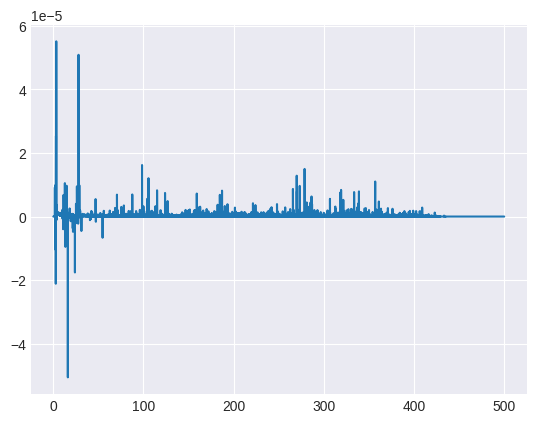

In [12]:
plt.plot(sim.t, (JLCC_ / Jxfer_).mean(axis=(1,2)))
plt.show()

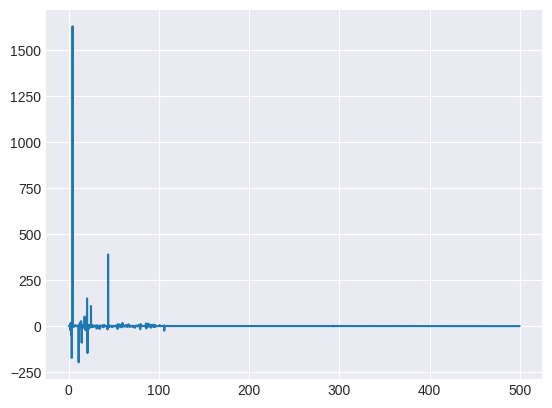

In [13]:
plt.plot(sim.t, (Jiss_ / Jxfer_).mean(axis=(1,2)))
plt.show()

In [15]:
Jxfer_reduced = (betass * Jxfer_).sum(axis=-1)
JLCC_reduced = (betass * JLCC_).sum(axis=-1)
Jiss_reduced = (betass * Jiss_).sum(axis=-1)
Jrel_reduced = (betass * Jrel_).sum(axis=-1)

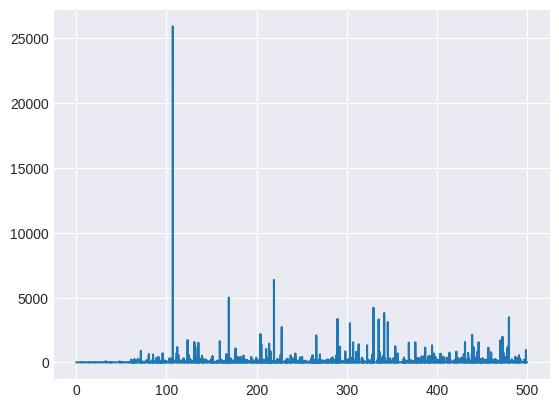

In [22]:
plt.plot(sim.t, (Jrel_reduced / Jxfer_reduced).max(axis=-1))
plt.show()

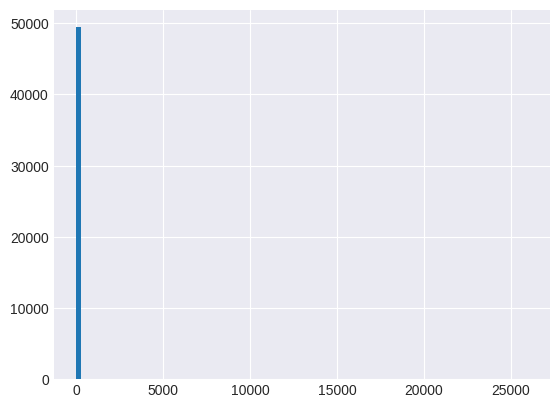

In [32]:
ratio = np.abs(Jrel_reduced / Jxfer_reduced).max(axis=-1)
plt.hist(ratio[ratio > 1], bins=100)
plt.show()

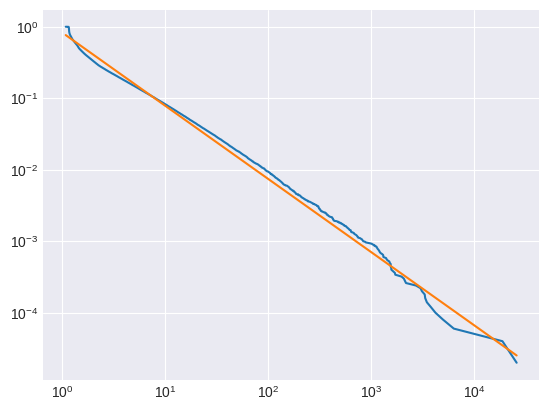

-2.0223375260268734


In [29]:
ratio = ratio[ratio > 0]
ps = np.arange(start=1, stop=ratio.reshape(-1)[ratio.reshape(-1) > 1].shape[0]+1) / ratio.reshape(-1)[ratio.reshape(-1) > 1].shape[0]
coeffs = np.polyfit(np.log(np.sort(ratio.reshape(-1)[ratio.reshape(-1) > 1])), np.log(ps[::-1]), 1)
plt.plot(np.sort(ratio.reshape(-1)[ratio.reshape(-1) > 1]), ps[::-1])
plt.plot(np.sort(ratio[ratio > 1]), np.exp(coeffs[1])*np.exp(coeffs[0]*np.log(np.sort(ratio[ratio > 1]))))
plt.xscale('log')
plt.yscale('log')
plt.show()
print(coeffs[0]-1)

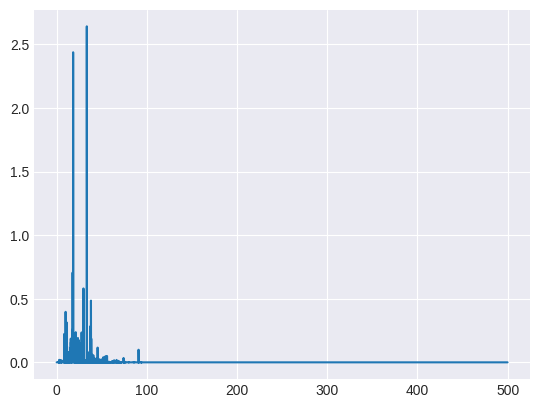

In [19]:
plt.plot(sim.t, (Jiss_reduced / Jxfer_reduced).max(axis=-1))
plt.show()

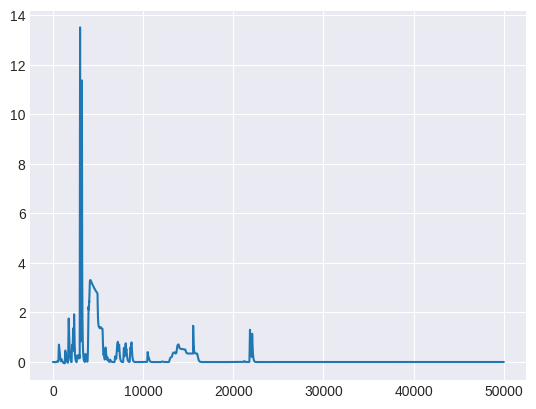

In [96]:
plt.plot((sim.CaSS[:,1,0] - sim.Cai) / sim.Cai)
plt.show()

In [89]:
sim.CaSS[:,0,0] - sim.Cai / sim.Cai
thresh_pos = np.where((sim.CaSS[:,0,0] - sim.Cai) / sim.Cai > 10)[0]

In [ ]:
threshold_plus = []
threshold_minus = []
for pos in thresh_pos:
    

In [8]:
CRU_ = CRU(sim)

In [67]:
CRU_.CRU_fwd(4000, 1, 100)

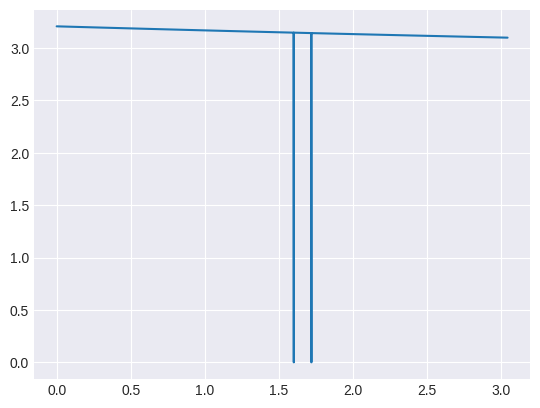

In [72]:
plt.plot(CRU_.times, CRU_.Jrel[:,0]) #/ CRU_.Jxfer)
plt.show()

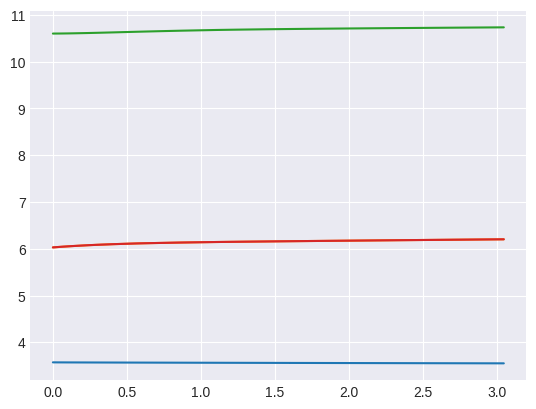

In [69]:
plt.plot(CRU_.times, CRU_.betaSS / CRU_.CaSS)
plt.show()

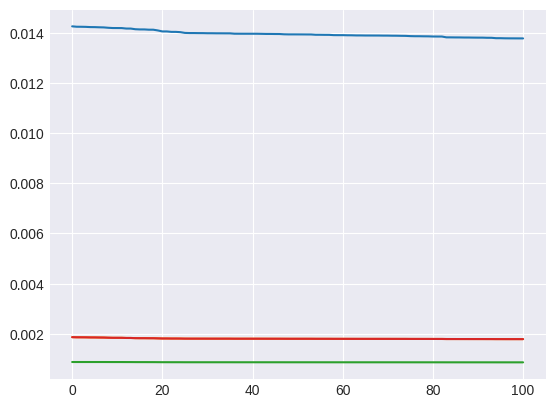

In [70]:
plt.plot(CRU_.CaSS)
plt.show()

In [73]:
CRU_.Jrel[:,0]

array([3.20607974, 3.20435909, 3.20413872, 3.20357922, 3.20214268,
       3.20180458, 3.20061241, 3.19972901, 3.19673982, 3.19451822,
       3.19434445, 3.19405561, 3.18993464, 3.18968298, 3.18381906,
       3.18197798, 3.18190774, 3.17955099, 3.17935625, 3.17258239,
       3.16346908, 3.16336274, 3.15934519, 3.15926067, 3.15660447,
       3.14966695, 3.14830184, 3.14827816, 3.14767238, 3.14752942,
       3.14652609, 3.14646446, 3.14586959, 0.        , 3.1458361 ,
       3.14575127, 3.14205399, 3.14182565, 3.14171952, 0.        ,
       3.14167451, 3.14158458, 3.1408599 , 3.13990562, 3.1398886 ,
       3.13936338, 3.1391665 , 3.1366351 , 3.13580861, 3.13577949,
       3.13563983, 3.13545006, 3.13513458, 3.1350024 , 3.1321664 ,
       3.13209466, 3.13154902, 3.13144165, 3.12880233, 3.12857626,
       3.12853526, 3.12752589, 3.12719711, 3.12601861, 3.12599298,
       3.12532816, 3.1252833 , 3.12506092, 3.12503406, 3.12432178,
       3.12428013, 3.12344746, 3.12320763, 3.1223403 , 3.12177

In [75]:
CRU_.RyR[:,0, 2:4].sum(axis=-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])